In [2]:
import numpy as np
import pandas as pd
import sqlalchemy as sql
import matplotlib.pyplot as plt
import plotly.express as px
import pycountry
import datetime
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

### NOTE: You will need to replicate the OONI db

Please see [our instructions for replicating the OONI DB on Amazon EC2](https://gist.github.com/elsehow/7e26f4949cb8fca3bf80b5de5be7f106).

Once you've done that, you can run this code on your EC2 instance

In [3]:
sql_engine = sql.create_engine('postgresql:///metadb')

# Compute interference rate for 2019

First, we find all reports for 2019, grouping by country code.

In [3]:
reports_2019 = pd.read_sql_query("SELECT COUNT(report_no), probe_cc from report where to_char(report.test_start_time, 'YYYY') = '2019' group by probe_cc", sql_engine)

In [4]:
reports_2019

count probe_cc
0         75       AD
1       7050       AE
2       1565       AF
3         52       AG
4         19       AI
5       2258       AL
6       2539       AM
7       3431       AO
8         22       AP
9      19805       AR
10         2       AS
11     11576       AT
12   1209467       AU
13        54       AW
14         5       AX
15      9140       AZ
16      1112       BA
17       112       BB
18      5158       BD
19      4779       BE
20      1890       BF
21      2442       BG
22       457       BH
23      1926       BI
24      2310       BJ
25        53       BM
26       479       BN
27      7367       BO
28         3       BQ
29    112314       BR
..       ...      ...
203     1483       TJ
204      262       TL
205     8183       TM
206    19224       TN
207        6       TO
208    63437       TR
209      493       TT
210        2       TV
211    22740       TW
212      631       TZ
213    69345       UA
214     1651       UG
215   596883       US
216     1516       UY
217    10973       UZ
218        6       VA
219       36       VC
220    21121       VE
221       36       VG
222       24       VI
223     4354       VN
224      130       VU
225       12       WF
226       55       WS
227    14188       YE
228       18       YT
229    15239       ZA
230     1620       ZM
231     3938       ZW
232   252399       ZZ

[233 rows x 2 columns]

Next, we'll find the total number of reports made in each country. This will allow us to compute our rates

Now, we'll find the number of *confirmed* and *anomolous* interference events in each country.

In [5]:
# some sample queries to help us see the schema...
pd.read_sql_query("SELECT * from ooexpl_wc_input_counts LIMIT 3", sql_engine)

input  confirmed_count  anomaly_count  \
0  http://www.desaparecidos.org/familiares/                0              0   
1   http://www.descoberto.mg.gov.br/portal/                0              0   
2   http://www.descoberto.mg.gov.br/portal/                0              0   

   failure_count  total_count   test_day bucket_date probe_cc  probe_asn  
0              0            1 2019-09-16  2019-09-16       AR      16814  
1              0            1 2019-09-16  2019-09-16       BR      28283  
2              0            2 2019-09-16  2019-09-16       BR      28573

In [12]:
probe_results_2019 = pd.read_sql_query("SELECT * from ooexpl_wc_input_counts where to_char(ooexpl_wc_input_counts.test_day, 'YYYY') = '2019'", sql_engine)

In [10]:
cc_by_probe_results_2019 = probe_results_2019.groupby('probe_cc').nunique()
cc_by_probe_results_2019.head()

confirmed_count  anomaly_count  probe_cc
probe_cc                                          
AD                      1              1         1
AE                      3              1         1
AF                      1              1         1
AG                      1              1         1
AL                      1              1         1

In [13]:
# calculate range of time that measurements_2019 spans
min_2019_time = min(probe_results_2019.test_day)
max_2019_time = max(probe_results_2019.test_day)

print(min_2019_time, "-", max_2019_time)

2019-08-02 00:00:00 - 2019-11-10 00:00:00


We'll now merge the probe results with the number of reports, so that we can compute the rates of confirmed/anomolous reports for each country.

In [11]:
df = cc_by_probe_results_2019[['confirmed_count', 'anomaly_count']]

In [12]:
interference_measurements_by_country=\
pd.DataFrame({'probe_cc': cc_by_num_reports_2019.index,
             'total': cc_by_num_reports_2019.values})\
    .merge(df, how='outer', left_on='probe_cc', right_on='probe_cc')

In [13]:
interference_measurements_by_country.head()

probe_cc  total  confirmed_count  anomaly_count
0       AD     75              1.0            1.0
1       AE   6882              3.0            1.0
2       AF   1557              1.0            1.0
3       AG     52              1.0            1.0
4       AI     19              NaN            NaN

In [14]:
interference_measurements_by_country.to_csv('interference-measurements-by-country-2019.csv')

Now, we have all of the data we need to compute rates. We can perform that analysis off of AWS. We are done for now!

# Lily's work

The below cells, until the section "Calculating 2019 Country-Specific Indices," include first steps for loading year-specific rows into CSV files for faster access. The final process used is further detailed in load_measurements.py.

### Saving 2018 Measurements to a CSV

First, we read in the wc_input_counts table, which associates an input domain name with confirmed / anomaly / failure counts.

In [ ]:
first_10_meas = pd.read_sql_query("SELECT * from ooexpl_wc_input_counts LIMIT 10", sql_engine)
first_10_meas.head()

The table is too large to read in all at once (the kernel dies), so we experiment with loading in a few rows incrementally.

In [ ]:
num_rows = pd.read_sql_query("SELECT COUNT(*) FROM (select * from ooexpl_wc_input_counts limit 10000000) meas", sql_engine)
num_rows

In [ ]:
pd.read_sql_query("SELECT distinct to_char(ooexpl_wc_input_counts.test_day, 'YYYY') from ooexpl_wc_input_counts", sql_engine)

We notice that the wc_input_counts table has a (possibly incomplete) set of 2019 measurements only.

In [ ]:
x = 10000000
meas_2018 = pd.read_sql_query("SELECT * from (select * from ooexpl_wc_input_counts limit " + str(x) + ") small_meas where to_char(small_meas.test_day, 'YYYY') = '2018'", sql_engine)
meas_2018.head()

In [ ]:
len(meas_2018)

Use the measurements table -- which is likely to be more thorough because it contains data from multiple years -- instead, loading rows incrementally into a dataframe.

In [ ]:
x = 10000000
meas_2018 = pd.read_sql_query("SELECT * from (select * from measurement limit " + str(x) + ") small_meas where to_char(small_meas.measurement_start_time, 'YYYY') = '2018'", sql_engine)
meas_2018.head()

The for loop runs 5 times because using a while loop causes the kernel to die as memory runs out. 

<b>Note (11/19/2019)</b>: meas_2018_full does not include all of the data rows for 2018.

In [ ]:
x = 10000000
meas_2018_full = meas_2018
count = 1
curr_meas = meas_2018
for i in range(5):
    if count != 1:
        meas_2018_full = meas_2018_full.append(curr_meas)
    next_query = "SELECT * from (select * from measurement offset " + str(count * x) + " rows limit " + str(x) + ") small_meas where to_char(small_meas.measurement_start_time, 'YYYY') = '2018'"
    print(next_query)
    curr_meas = pd.read_sql_query(next_query, sql_engine)
    count += 1

In [ ]:
meas_2018_full.head()

In [ ]:
len(meas_2018_full)

Write 2018 measurement rows to a csv file so they're easier to reload in the future.

In [ ]:
meas_2018_full.to_csv("measurements_2018.csv")

### Reading 2018 Measurements from CSV

Start from here in the future -- data has already been written to a csv file and now needs to be reloaded.

In [ ]:
meas_2018_read = pd.read_csv("measurements_2018.csv")
meas_2018_read.head()

In [ ]:
len(meas_2018_read)

Join the loaded 2018 measurements with the reports table to associate each measurement with the report's country code.

In [ ]:
reports_2018 = pd.read_sql_query("SELECT * from report where to_char(report.test_start_time, 'YYYY') = '2018'", sql_engine)
reports_2018.head()

In [ ]:
len(reports_2018)

Merge the 2018 measurements with the 2018 reports table to associate each measurement with a confirmed / anomaly data point (these are only associated with reports).

In [ ]:
meas_report_join = meas_2018_read.merge(reports_2018, on = "report_no", how = "left")
meas_report_join.head()

In [ ]:
len(meas_report_join)

In [ ]:
meas_report_join.columns

Check to see the number of unique probe_cc (all country codes) and confirmed (True / False) values.

In [ ]:
meas_report_join.groupby("probe_cc").nunique()["report_no"]

In [ ]:
meas_report_join.groupby("confirmed").nunique()["report_no"]

Group confirmed, anomalous events by country code, and calculate strict ($\frac{\text{confirmed}}{\text{number of reports}}$) and loose rates ($\frac{\text{confirmed + anomalous}}{\text{number of reports}}$).

In [ ]:
# count confirmed by country
country_groups = meas_report_join.groupby("probe_cc")
country_groups.first()

In [ ]:
rates_2018 = country_groups.agg({"confirmed": "sum", "anomaly": "sum", "report_no": "count"})
rates_2018.head()

In [ ]:
rates_2018.loc[rates_2018["confirmed"] > 0]

In [ ]:
rates_2018["strict_rate"] = rates_2018['confirmed'] / rates_2018['report_no']
rates_2018["loose_rate"] = (rates_2018['confirmed'] + rates_2018['anomaly']) / rates_2018['report_no']
rates_2018["num_no_confirmed_interference"] = rates_2018["report_no"] - rates_2018['confirmed']

In [ ]:
rates_2018.head()

In [ ]:
rates_2018.drop(['report_no'], axis = 1, inplace = True)
rates_2018.head()

Clean up the table by renaming the index and changing the order of the columns (especially the rate calculations, which should be at the right) to make the saved 2018 interference measurements csv file more readable.

In [ ]:
rates_2018 = rates_2018.rename(index = {"probe_cc": "country_code"}, columns={'confirmed': 'num_confirmed_interference', 'anomaly': "num_anomaly"})

In [ ]:
rates_2018.head()

In [ ]:
rates_2018 = rates_2018.rename_axis("country_code")
rates_2018.head()

In [ ]:
columnsTitles = ["num_confirmed_interference", "num_anomaly", "num_no_confirmed_interference", "strict_rate", "loose_rate"]
new_rates_2018 = rates_2018.reindex(columns = columnsTitles)
new_rates_2018.head()

In [ ]:
new_rates_2018.to_csv("interference-measurements-by-country-2018.csv")

## Measurements Analysis: 2019

### Saving 2019 Measurements to a CSV

Repeat the process of generating strict and loose rates on measurement table data for 2019 as a sanity check for the wc_counts table analysis. <b>Note</b>: This is not the code actually used to populate measurements_2019.csv -- check load_measurements.py in the same directory for similar code for this purpose. A Python script was used instead of a Jupyter notebook cell to prevent the kernel from running out of memory.

In [ ]:
x = 10000000
meas_2019 = pd.read_sql_query("SELECT * from (select * from measurement limit " + str(x) + ") small_meas where to_char(small_meas.measurement_start_time, 'YYYY') = '2019'", sql_engine)

meas_2019_full = meas_2019
count = 1
curr_meas = meas_2019
while len(curr_meas) > 0:
    if count != 1:
        meas_2019_full = meas_2019_full.append(curr_meas)
    next_query = "SELECT * from (select * from measurement offset " + str(count * x) + " rows limit " + str(x) + ") small_meas where to_char(small_meas.measurement_start_time, 'YYYY') = '2019'"
    print(next_query)
    curr_meas = pd.read_sql_query(next_query, sql_engine)
    count += 1

SELECT * from (select * from measurement offset 10000000 rows limit 10000000) small_meas where to_char(small_meas.measurement_start_time, 'YYYY') = '2019'


### Reading 2019 Measurements from a CSV

Load all 2019 measurement row to a local dataframe, and check the schema of the resulting table.

<b>Note (11/19/2019)</b>: There are 7772520 rows in this table, which is less than expected.

In [3]:
meas_2019_read = pd.read_csv("measurements_2019.csv")
meas_2019_read.head()

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (12,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Unnamed: 0     msm_no  report_no  frame_off  frame_size  intra_off  \
0           0  330983634   10093634    8493197       36428      25247   
1           1  330983635   10093634    8493197       36428      28161   
2           2  330983636   10093634    8493197       36428      30481   
3           3  330983637   10093634    8493197       36428      32520   
4           4  330983638   10093634    8493197       36428      34983   

   intra_size measurement_start_time  test_runtime  \
0        2913    2019-08-21 00:56:22       5.33969   
1        2319    2019-08-21 00:56:27       3.42277   
2        2038    2019-08-21 00:56:30       3.57306   
3        2462    2019-08-21 00:56:34       1.87497   
4        2383    2019-08-21 00:56:36       1.28084   

                    orig_sha1                                    id  \
0  <memory at 0x7f62393e64c8>  524dbc77-ce97-4b9d-b503-006f2da5c680   
1  <memory at 0x7f62393e6588>  555d1404-632f-43a2-936d-12b55a0b9559   
2  <memory at 0x7f62393e6648>  371ed0f7-460b-4d99-8d38-78d30b8ec782   
3  <memory at 0x7f62393e6708>  4c5a6d00-9eb6-4800-b7d4-6ae98d4557bc   
4  <memory at 0x7f62393e67c8>  a1df8445-412d-47a4-b334-82a0f21320c6   

     input_no  exc  residual_no  msm_failure anomaly confirmed  
0  12157831.0  NaN       848346          NaN    True       NaN  
1   4956603.0  NaN       848346          NaN    True       NaN  
2  12227622.0  NaN       848346          NaN    True       NaN  
3  11901343.0  NaN       848346          NaN    True       NaN  
4  11882816.0  NaN       848346          NaN    True       NaN

In [4]:
len(meas_2019_read)

7772520

<b>Note</b>: Run the two cells below only once.

Join all 2019 measurement rows with reports from the year 2019. Save relevant reports to a csv file to cache results intermediately.

In [ ]:
reports_2019 = pd.read_sql_query("SELECT * from report where to_char(report.test_start_time, 'YYYY') = '2019'", sql_engine)
reports_2019.head()

In [6]:
reports_2019.to_csv("reports/reports-2019.csv")

Start from here in the future to load all reports rows already written to an existing file.

In [40]:
reports_2019 = pd.read_csv("reports/reports-2019.csv")

Note that the number of 2019 reports is 3985511, indicating that we likely have multiple measurements corresponding to the same report.

In [6]:
len(reports_2019)

3985511

In [7]:
meas_report_join_2019 = meas_2019_read.merge(reports_2019, on = "report_no", how = "left")
meas_report_join_2019.head()

Unnamed: 0_x     msm_no  report_no  frame_off  frame_size  intra_off  \
0             0  330983634   10093634    8493197       36428      25247   
1             1  330983635   10093634    8493197       36428      28161   
2             2  330983636   10093634    8493197       36428      30481   
3             3  330983637   10093634    8493197       36428      32520   
4             4  330983638   10093634    8493197       36428      34983   

   intra_size measurement_start_time  test_runtime  \
0        2913    2019-08-21 00:56:22       5.33969   
1        2319    2019-08-21 00:56:27       3.42277   
2        2038    2019-08-21 00:56:30       3.57306   
3        2462    2019-08-21 00:56:34       1.87497   
4        2383    2019-08-21 00:56:36       1.28084   

                  orig_sha1_x  ...      test_start_time  probe_cc probe_asn  \
0  <memory at 0x7f62393e64c8>  ...  2019-08-21 00:38:16        US   30600.0   
1  <memory at 0x7f62393e6588>  ...  2019-08-21 00:38:16        US   30600.0   
2  <memory at 0x7f62393e6648>  ...  2019-08-21 00:38:16        US   30600.0   
3  <memory at 0x7f62393e6708>  ...  2019-08-21 00:38:16        US   30600.0   
4  <memory at 0x7f62393e67c8>  ...  2019-08-21 00:38:16        US   30600.0   

   probe_ip         test_name badtail  \
0       NaN  web_connectivity     NaN   
1       NaN  web_connectivity     NaN   
2       NaN  web_connectivity     NaN   
3       NaN  web_connectivity     NaN   
4       NaN  web_connectivity     NaN   

                                            textname  \
0  2019-08-21/20190821T003816Z-US-AS30600-web_con...   
1  2019-08-21/20190821T003816Z-US-AS30600-web_con...   
2  2019-08-21/20190821T003816Z-US-AS30600-web_con...   
3  2019-08-21/20190821T003816Z-US-AS30600-web_con...   
4  2019-08-21/20190821T003816Z-US-AS30600-web_con...   

                  orig_sha1_y  \
0  <memory at 0x7f1e1a348648>   
1  <memory at 0x7f1e1a348648>   
2  <memory at 0x7f1e1a348648>   
3  <memory at 0x7f1e1a348648>   
4  <memory at 0x7f1e1a348648>   

                                           report_id software_no  
0  20190821T003817Z_AS30600_kSOmF9EhCEZUvrj4xfEc8...       670.0  
1  20190821T003817Z_AS30600_kSOmF9EhCEZUvrj4xfEc8...       670.0  
2  20190821T003817Z_AS30600_kSOmF9EhCEZUvrj4xfEc8...       670.0  
3  20190821T003817Z_AS30600_kSOmF9EhCEZUvrj4xfEc8...       670.0  
4  20190821T003817Z_AS30600_kSOmF9EhCEZUvrj4xfEc8...       670.0  

[5 rows x 29 columns]

Check the number of rows in the joined table to ensure that no measurements have been mistakenly dropped.

In [8]:
len(meas_report_join_2019)

7772520

### Calculating 2019 Country-Specific Indices

We group all of the joined measurement-report rows by country code so we can make aggregated calculations for confirmed / anomalous events.

In [9]:
# count confirmed by country
country_groups = meas_report_join_2019.groupby("probe_cc")
country_groups.first()

Unnamed: 0_x     msm_no  report_no  frame_off  frame_size  \
probe_cc                                                              
AD              489638  333464474   10189456     594370       22842   
AE               28018  331011652   10096881    2725956       59466   
AF               31090  331014724   10099953    6549972       61931   
AG              452580  340247871   10472710   10077478       59675   
AI              610186  351417780   11048436   10239371       55757   
AL               29290  331012924   10098153    4328958       60041   
AM               28077  331011711   10096940    2785422       62593   
AO               27294  331010928   10096157    1862144       61514   
AP                  41  260140560    7204854    3314659       81515   
AR                1602  330985236   10093679    6493529       60571   
AT                2601  330986235   10093698    3026877       81089   
AU                7601  330991235   10093803      90016       17906   
AW              674872  331658796   10126388    8200496       60513   
AX               29550  331013184   10098413    4629342       64430   
AZ               25993  331009627   10094856     185683       62864   
BA                5908  330989542   10093743     522597       70902   
BB              363996  331347816   10109371    2517539       60467   
BD               27937  331011571   10096800    2604312       60308   
BE                2938  330986572   10093707   12483422       72631   
BF              365472  331349292   10110847    4358548       57801   
BG               31380  331015014   10100243    6851860       58709   
BH              366308  331350128   10111683    5324611       60596   
BI               28807  331012441   10097670    3710371       62831   
BJ               28530  331012164   10097393    3337868       60290   
BM              976043  331959967   10134446    4118145       58750   
BN               28549  331012183   10097412    3398158       62114   
BO               26075  331009709   10094938     309748       64558   
BR                1315  330984949   10093641          0       88633   
BS              930270  324927299    9867544     130701        9800   
BT              497328  333472164   10190309          0       60885   
...                ...        ...        ...        ...         ...   
TD               29201  331012835   10098064    4207256       62052   
TG               31069  331014703   10099932    6491144       58828   
TH                7716  330991350   10093918     498741       22435   
TJ               27132  331010766   10095995    1686214       55895   
TL               29930  331013564   10098793    5125477       62391   
TM               21161  331004795   10094619    8437157       79078   
TN               25842  331009476   10094705          0       58424   
TO              746284  345541473   10729008    6445095       61479   
TR                7756  330991390   10093958     611946       24351   
TT               28954  331012588   10097817    3897304       61775   
TW               25911  331009545   10094774     121983       63700   
TZ              189192  333172342   10184035    6055747       62715   
UA                2556  330986190   10093696    1938928      154476   
UG              365496  331349316   10110871    4358548       57801   
US                   0  330983634   10093634    8493197       36428   
UY               27975  331011609   10096838    2664620       61336   
UZ               25955  331009589   10094818     185683       62864   
VA               53982  350859014   11005456     447035        8885   
VC               83680  339878971   10450588      57310       60614   
VE                7638  330991272   10093840     206006       26045   
VG              306772  351111804   11023964      56954       60391   
VN                1649  330985283   10093682    8646004       48521   
VU              736151  331720075   10128866    7702021      102621   
WF              921959  351729583 

Calculate strict and loose rates similarly to the 2018 analysis, and reformat the resulting table to increase readability before writing to a file.

In [11]:
rates_2019 = country_groups.agg({"confirmed": "sum", "anomaly": "sum", "report_no": "count"})
rates_2019["strict_rate"] = rates_2019['confirmed'] / rates_2019['report_no']
rates_2019["loose_rate"] = (rates_2019['confirmed'] + rates_2019['anomaly']) / rates_2019['report_no']
rates_2019["num_no_confirmed_interference"] = rates_2019["report_no"] - rates_2019['confirmed']
rates_2019.head()

report_no  confirmed  anomaly  strict_rate  loose_rate  \
probe_cc                                                           
AD               50          0        0     0.000000    0.000000   
AE             2037        292      401     0.143348    0.340206   
AF              209          0        8     0.000000    0.038278   
AG                4          0        0     0.000000    0.000000   
AI                1          0        0     0.000000    0.000000   

          num_no_confirmed_interference  
probe_cc                                 
AD                                   50  
AE                                 1745  
AF                                  209  
AG                                    4  
AI                                    1

Drop the report_no column, which isn't relevant to index calculations, and rename columns and the index axis.

In [12]:
rates_2019.drop(['report_no'], axis = 1, inplace = True)
rates_2019 = rates_2019.rename(index = {"probe_cc": "country_code"}, columns={'confirmed': 'num_confirmed_interference', 'anomaly': "num_anomaly"})
rates_2019 = rates_2019.rename_axis("country_code")

rates_2019.head()

num_confirmed_interference  num_anomaly  strict_rate  \
country_code                                                         
AD                                     0            0     0.000000   
AE                                   292          401     0.143348   
AF                                     0            8     0.000000   
AG                                     0            0     0.000000   
AI                                     0            0     0.000000   

              loose_rate  num_no_confirmed_interference  
country_code                                             
AD              0.000000                             50  
AE              0.340206                           1745  
AF              0.038278                            209  
AG              0.000000                              4  
AI              0.000000                              1

Specify the order of the columns in the final dataframe and write to a csv file.

In [13]:
columnsTitles = ["num_confirmed_interference", "num_anomaly", "num_no_confirmed_interference", "strict_rate", "loose_rate"]
new_rates_2019 = rates_2019.reindex(columns = columnsTitles)
new_rates_2019.head()

num_confirmed_interference  num_anomaly  \
country_code                                            
AD                                     0            0   
AE                                   292          401   
AF                                     0            8   
AG                                     0            0   
AI                                     0            0   

              num_no_confirmed_interference  strict_rate  loose_rate  
country_code                                                          
AD                                       50     0.000000    0.000000  
AE                                     1745     0.143348    0.340206  
AF                                      209     0.000000    0.038278  
AG                                        4     0.000000    0.000000  
AI                                        1     0.000000    0.000000

In [14]:
new_rates_2019.to_csv("interference-measurements-by-country-2019-sanity.csv")

### Comparing wc_counts to measurement data

The file interference-measurements-by-country-2019-sanity.csv was generated by calculating with the measurements table while interference-measurements-by-country-2019.csv is based on wc_counts table analysis. In this section, we note their differences in number of events and rate calculations to decide which rates are more accurate.

In [15]:
# generated by measurements table joined with reports table
interference_2019_sanity = pd.read_csv("interference-measurements-by-country-2019-sanity.csv")

# generated by wc_count table joined with reports table
interference_2019 = pd.read_csv('interference-measurements-by-country-2019.csv')

In [16]:
interference_2019_sanity.head()

country_code  num_confirmed_interference  num_anomaly  \
0           AD                           0            0   
1           AE                         292          401   
2           AF                           0            8   
3           AG                           0            0   
4           AI                           0            0   

   num_no_confirmed_interference  strict_rate  loose_rate  
0                             50     0.000000    0.000000  
1                           1745     0.143348    0.340206  
2                            209     0.000000    0.038278  
3                              4     0.000000    0.000000  
4                              1     0.000000    0.000000

In [17]:
interference_2019.head()

Unnamed: 0 probe_cc  total  confirmed_count  anomaly_count
0           0       AD     75              1.0            1.0
1           1       AE   6882              3.0            1.0
2           2       AF   1557              1.0            1.0
3           3       AG     52              1.0            1.0
4           4       AI     19              NaN            NaN

Note that the number of total events are different between the 2 tables and the numbers of anomalous and confirmed events per country are comparatively low in interference_2019 compared to interference_2019_sanity.

In [18]:
interference_2019_sanity.head(20)

country_code  num_confirmed_interference  num_anomaly  \
0            AD                           0            0   
1            AE                         292          401   
2            AF                           0            8   
3            AG                           0            0   
4            AI                           0            0   
5            AL                           0            2   
6            AM                           0            2   
7            AO                           0            3   
8            AP                           0            0   
9            AR                           0         7182   
10           AT                           0          809   
11           AU                           0        12603   
12           AW                           0            0   
13           AX                           0            0   
14           AZ                           0            3   
15           BA                           0           15   
16           BB                           0            0   
17           BD                           0          227   
18           BE                          93          416   
19           BF                           0            0   

    num_no_confirmed_interference  strict_rate  loose_rate  
0                              50     0.000000    0.000000  
1                            1745     0.143348    0.340206  
2                             209     0.000000    0.038278  
3                               4     0.000000    0.000000  
4                               1     0.000000    0.000000  
5                             379     0.000000    0.005277  
6                             236     0.000000    0.008475  
7                             374     0.000000    0.008021  
8                               1     0.000000    0.000000  
9                           90981     0.000000    0.078940  
10                          68595     0.000000    0.011794  
11                         159027     0.000000    0.079251  
12                              5     0.000000    0.000000  
13                              3     0.000000    0.000000  
14                            865     0.000000    0.003468  
15                            567     0.000000    0.026455  
16                             31     0.000000    0.000000  
17                           3652     0.000000    0.062158  
18                           8235     0.011167    0.061119  
19                            133     0.000000    0.000000

In [19]:
interference_2019.head(20)

Unnamed: 0 probe_cc    total  confirmed_count  anomaly_count
0            0       AD       75              1.0            1.0
1            1       AE     6882              3.0            1.0
2            2       AF     1557              1.0            1.0
3            3       AG       52              1.0            1.0
4            4       AI       19              NaN            NaN
5            5       AL     2239              1.0            1.0
6            6       AM     2475              1.0            1.0
7            7       AO     3399              1.0            1.0
8            8       AP       22              NaN            NaN
9            9       AR    19599              1.0            1.0
10          10       AS        2              NaN            NaN
11          11       AT    11434              1.0            1.0
12          12       AU  1194527              1.0            1.0
13          13       AW       54              NaN            NaN
14          14       AX        5              NaN            NaN
15          15       AZ     9052              1.0            1.0
16          16       BA     1102              1.0            1.0
17          17       BB      111              1.0            1.0
18          18       BD     5114              1.0            1.0
19          19       BE     4728              5.0            1.0

Examine the meas_report_join_2019 table to see whether interference_2019_sanity is ignoring some types of tests that would then need to be accounted for from other tables.

In [21]:
meas_report_join_2019.head()

Unnamed: 0_x     msm_no  report_no  frame_off  frame_size  intra_off  \
0             0  330983634   10093634    8493197       36428      25247   
1             1  330983635   10093634    8493197       36428      28161   
2             2  330983636   10093634    8493197       36428      30481   
3             3  330983637   10093634    8493197       36428      32520   
4             4  330983638   10093634    8493197       36428      34983   

   intra_size measurement_start_time  test_runtime  \
0        2913    2019-08-21 00:56:22       5.33969   
1        2319    2019-08-21 00:56:27       3.42277   
2        2038    2019-08-21 00:56:30       3.57306   
3        2462    2019-08-21 00:56:34       1.87497   
4        2383    2019-08-21 00:56:36       1.28084   

                  orig_sha1_x  ...      test_start_time  probe_cc probe_asn  \
0  <memory at 0x7f62393e64c8>  ...  2019-08-21 00:38:16        US   30600.0   
1  <memory at 0x7f62393e6588>  ...  2019-08-21 00:38:16        US   30600.0   
2  <memory at 0x7f62393e6648>  ...  2019-08-21 00:38:16        US   30600.0   
3  <memory at 0x7f62393e6708>  ...  2019-08-21 00:38:16        US   30600.0   
4  <memory at 0x7f62393e67c8>  ...  2019-08-21 00:38:16        US   30600.0   

   probe_ip         test_name badtail  \
0       NaN  web_connectivity     NaN   
1       NaN  web_connectivity     NaN   
2       NaN  web_connectivity     NaN   
3       NaN  web_connectivity     NaN   
4       NaN  web_connectivity     NaN   

                                            textname  \
0  2019-08-21/20190821T003816Z-US-AS30600-web_con...   
1  2019-08-21/20190821T003816Z-US-AS30600-web_con...   
2  2019-08-21/20190821T003816Z-US-AS30600-web_con...   
3  2019-08-21/20190821T003816Z-US-AS30600-web_con...   
4  2019-08-21/20190821T003816Z-US-AS30600-web_con...   

                  orig_sha1_y  \
0  <memory at 0x7f1e1a348648>   
1  <memory at 0x7f1e1a348648>   
2  <memory at 0x7f1e1a348648>   
3  <memory at 0x7f1e1a348648>   
4  <memory at 0x7f1e1a348648>   

                                           report_id software_no  
0  20190821T003817Z_AS30600_kSOmF9EhCEZUvrj4xfEc8...       670.0  
1  20190821T003817Z_AS30600_kSOmF9EhCEZUvrj4xfEc8...       670.0  
2  20190821T003817Z_AS30600_kSOmF9EhCEZUvrj4xfEc8...       670.0  
3  20190821T003817Z_AS30600_kSOmF9EhCEZUvrj4xfEc8...       670.0  
4  20190821T003817Z_AS30600_kSOmF9EhCEZUvrj4xfEc8...       670.0  

[5 rows x 29 columns]

The measurements table includes a large number of each type of test (this can't be confirmed for wc_counts because its data is already aggregated).

In [24]:
meas_report_join_2019['test_name'].unique()

array(['web_connectivity', 'http_requests', 'whatsapp',
       'facebook_messenger', 'ndt', 'meek_fronted_requests_test',
       'http_invalid_request_line', 'tcp_connect', 'dash', 'telegram',
       'http_header_field_manipulation', 'vanilla_tor', nan], dtype=object)

In [27]:
meas_report_join_2019.groupby('test_name').nunique()

Unnamed: 0_x   msm_no  report_no  frame_off  \
test_name                                                                     
dash                                   17188    17893      17893       2762   
facebook_messenger                      9378     9512       9512        830   
http_header_field_manipulation         11588    11676      11674        717   
http_invalid_request_line              13146    13299      13294        942   
http_requests                          25841    26270        254       7293   
meek_fronted_requests_test              6856     6890       4300        274   
ndt                                   198693   237604     237604      21875   
tcp_connect                           657622  1008405      20615      18646   
telegram                               17088    17145      17142       2017   
vanilla_tor                             3665     3674       3670        239   
web_connectivity                     1000000  6409468      90008    2261991   
whatsapp                               10330    10410      10403       3613   

                                frame_size  intra_off  intra_size  \
test_name                                                           
dash                                  2403      14476        1677   
facebook_messenger                     785       5044         529   
http_header_field_manipulation         731       5308         736   
http_invalid_request_line              988       6763         614   
http_requests                         7186      21500       12698   
meek_fronted_requests_test             381       4749         198   
ndt                                   8970     109496        4100   
tcp_connect                           2714     243610         119   
telegram                              1742       9745        1427   
vanilla_tor                            350       1882         836   
web_connectivity                    273944     260678      557609   
whatsapp                              3407       7512        3138   

                                measurement_start_time  test_runtime  \
test_name                                                              
dash                                             17818         16547   
facebook_messenger                                9435          9457   
http_header_field_manipulation                   11591         11568   
http_invalid_request_line                        13144         11670   
http_requests                                    21056         25930   
meek_fronted_requests_test                        4659          6843   
ndt                                             226829        148513   
tcp_connect                                     476602        609707   
telegram                                         17117         16824   
vanilla_tor                                       3587          3609   
web_connectivity                               2684163       1717068   
whatsapp                                         10307         10317   

                                orig_sha1_x  ...  test_start_time  probe_cc  \
test_name                                    ...                              
dash                                  17893  ...            17818       145   
facebook_messenger                     9512  ...             9447       144   
http_header_field_manipulation        11676  ...            11575       150   
http_invalid_request_line             13299  ...            13133       146   
http_requests                         26270  ...              219        14   
meek_fronted_requests_test             6890  ...             4237        68   
ndt                                  237604  ...           227050       211   
tcp_connect                         1008405  ...            20034        71   
telegram                              17145  ...            17115       168   
vanilla_tor                            3674  ...             3593        67   
w

Most other tables, including vanilla_tor, include metadata about the corresponding tests instead of pass / failure.

In [28]:
pd.read_sql_query("SELECT * from vanilla_tor LIMIT 5", sql_engine)

msm_no  timeout error  tor_progress  success tor_progress_tag  \
0  143225631      300  None           100     True             done   
1  143225632      300  None           100     True             done   
2  143225633      300  None           100     True             done   
3  143225634      300  None           100     True             done   
4  143225635      300  None           100     True             done   

  tor_progress_summary tor_version  \
0                 Done    0.2.9.10   
1                 Done     0.3.1.7   
2                 Done     0.3.1.8   
3                 Done     0.3.1.7   
4                 Done     0.2.8.8   

                                             tor_log  
0  [{'t': 0, '_': '[notice] Tor 0.2.9.10 (git-e28...  
1  [{'t': 0, '_': '[notice] Tor 0.3.1.7 (git-6bab...  
2  [{'t': 0, '_': '[warn] OpenSSL version from he...  
3  [{'t': 0, '_': '[notice] Tor 0.3.1.7 (git-6bab...  
4  [{'t': 0, '_': '[notice] Tor v0.2.8.8 (git-8d8...

In [32]:
meas_report_join_2019.columns

Index(['Unnamed: 0_x', 'msm_no', 'report_no', 'frame_off', 'frame_size',
       'intra_off', 'intra_size', 'measurement_start_time', 'test_runtime',
       'orig_sha1_x', 'id', 'input_no', 'exc', 'residual_no', 'msm_failure',
       'anomaly', 'confirmed', 'Unnamed: 0_y', 'autoclaved_no',
       'test_start_time', 'probe_cc', 'probe_asn', 'probe_ip', 'test_name',
       'badtail', 'textname', 'orig_sha1_y', 'report_id', 'software_no'],
      dtype='object')

In [34]:
pd.read_sql_query("SELECT * from input LIMIT 5", sql_engine)

input_no                      input
0         1       http://www.pdhre.org
1         2      http://login.live.com
2         3   http://www.neonjoint.com
3         4  http://www.wiesenthal.com
4         5           http://deoxy.org

Check to see that a specific input domain can be associated with each measurement pass / failure. We can do some analysis later to see which domains result in the most failures / anomalies in different countries.

In [35]:
inputs = pd.read_sql_query("SELECT * from input", sql_engine)
meas_input_join_2019 = meas_2019_read.merge(inputs, on = "input_no", how = "left")

In [36]:
meas_input_join_2019.head()

Unnamed: 0     msm_no  report_no  frame_off  frame_size  intra_off  \
0           0  330983634   10093634    8493197       36428      25247   
1           1  330983635   10093634    8493197       36428      28161   
2           2  330983636   10093634    8493197       36428      30481   
3           3  330983637   10093634    8493197       36428      32520   
4           4  330983638   10093634    8493197       36428      34983   

   intra_size measurement_start_time  test_runtime  \
0        2913    2019-08-21 00:56:22       5.33969   
1        2319    2019-08-21 00:56:27       3.42277   
2        2038    2019-08-21 00:56:30       3.57306   
3        2462    2019-08-21 00:56:34       1.87497   
4        2383    2019-08-21 00:56:36       1.28084   

                    orig_sha1                                    id  \
0  <memory at 0x7f62393e64c8>  524dbc77-ce97-4b9d-b503-006f2da5c680   
1  <memory at 0x7f62393e6588>  555d1404-632f-43a2-936d-12b55a0b9559   
2  <memory at 0x7f62393e6648>  371ed0f7-460b-4d99-8d38-78d30b8ec782   
3  <memory at 0x7f62393e6708>  4c5a6d00-9eb6-4800-b7d4-6ae98d4557bc   
4  <memory at 0x7f62393e67c8>  a1df8445-412d-47a4-b334-82a0f21320c6   

     input_no  exc  residual_no  msm_failure anomaly confirmed  \
0  12157831.0  NaN       848346          NaN    True       NaN   
1   4956603.0  NaN       848346          NaN    True       NaN   
2  12227622.0  NaN       848346          NaN    True       NaN   
3  11901343.0  NaN       848346          NaN    True       NaN   
4  11882816.0  NaN       848346          NaN    True       NaN   

                                   input  
0               http://www.ananzi.co.za/  
1        http://www.angelfire.lycos.com/  
2      http://www.anglicancommunion.org/  
3             http://www.angryharry.com/  
4  http://www.animalliberationfront.com/

Examine the number of rows where a user ran a test on the domain 'https://www.buydutchseeds.com/'.

In [37]:
meas_input_join_2019.loc[meas_input_join_2019.input == 'https://www.buydutchseeds.com/']

Unnamed: 0     msm_no  report_no  frame_off  frame_size  intra_off  \
71               71  330983705   10093634    8493197       36428     213624   
1569           1569  330985203   10093677    5193224      178791     150965   
1919           1919  330985553   10093686   13477908      153849      47259   
2851           2851  330986485   10093705   10705924       57759          1   
9650           9650  330993284   10094142    8458534       36662      78424   
10885         10885  330994519   10094143    8906432       35893     240404   
19170         19170  331002804   10094605    6864763       33014      42562   
24072         24072  331007706   10094643    7379116       23921      96699   
34764         34764  331018398   10102451   11750272       72205          1   
35330         35330  331018964   10102466    6957314       97590     116648   
37049         37049  331020683   10102510     145428       37002      68744   
40841         40841  331024475   10102567     144898       36720      60762   
42770         42770  331026404   10102575    8432171       31395     220884   
44792         44792  331028426   10102732   11359251       37021      40055   
94906         94906  331078711   10103653    9128454       36694      54437   
96177         96177  331079982   10103655   10912540       36322      64475   
101883       101883  331085688   10104653   11803665       89102     246217   
102687       102687  331086492   10104702     226562       58480      58965   
108092       108092  331091897   10105634    1013556       71999          1   
109473       109473  331093278   10105662   11876069       59166     121882   
110975       110975  331094780   10105663    9120583       79923     116246   
112210       112210  331096015   10105664    9102182       77158      34704   
113447       113447  331097252   10105665    9292485       57492      37670   
114680       114680  331098485   10105666    8526737       91771      34856   
117363       117363  331101168   10105668   11355051      101573      87377   
118972       118972  331102777   10105669    8483897       96989     116213   
120207       120207  331104012   10105670    9124128       64425      34858   
121442       121442  331105247   10105671    9160453       80116     118327   
122678       122678  331106483   10105672    9138037       71302     116262   
123914       123914  331107719   10105673    9054411       64500      37767   
...             ...        ...        ...        ...         ...        ...   
7728146       76796  280459341    7963660   10873801       80413       6708   
7730879       79529  281152420    8025450   11255579       93173     128389   
7731145       79795  281216054    8045164    3585365       70154     183263   
7732953       81603  281668720    8104399   20509770      247351          1   
7735738       84388  282379356    8187987    9074512       87489     121744   
7739756       88406  283357969    8254556    9101303      117333      34854   
7740265       88915  283483466    8254658    8464669       49991     114959   
7745770       94420  284887155    8315841    4997492       63620      88635   
7746473       95123  285068716    8317547   10985724      108013      48627   
7746668       95318  285117603    8318562   13300589      103656      84507   
7747039       95689  285211525    8327871    7130681       71947          1   
7747175       95825  285247765    8327905    9274204       76765     125076   
7748218       96868  285510036    8337887   16794717       58405     260731   
7750715       99365  286147694    8361491    8366682      109013     122297   
7753387      102037  286809627    8384696    9012966       69498     122235   
7755509      104159  287346032    8405965    8500635       71305      48615   
7757738      106388  287923749    8425969   36035683       54324      34916   
7758583      107233  288139543    8436626   27286455       93331     176494   
7759985      108635  288503394    8447546    8926717       

This is a clue that there may be inaccuracies with the times and / or number of rows in the dataframe. At the time this was run, 2019-11-25 hadn't passed yet.

In [40]:
# calculate range of time that measurements_2019 spans
min_2019_time = min(meas_2019_read.measurement_start_time)
max_2019_time = max(meas_2019_read.measurement_start_time)

print(min_2019_time, "-", max_2019_time)

2019-01-01 00:00:18 - 2019-11-25 18:03:03


We see that the number of rows in meas_2019 (~7 mil) is not complete -- we expect to analyze 96856475 rows.

In [ ]:
# NOTE: Run each query individually to prevent kernel from crashing.

total_rows_query = "SELECT COUNT(*) from measurement"
# output: 301217670

rows_2017_query = "SELECT COUNT(*) from measurement where to_char(measurement.measurement_start_time, 'YYYY') = '2017'"
# output: 70626297

rows_2018_query = "SELECT COUNT(*) from measurement where to_char(measurement.measurement_start_time, 'YYYY') = '2018'"
# output: 108772822

rows_2019_query = "SELECT COUNT(*) from measurement where to_char(measurement.measurement_start_time, 'YYYY') = '2019'"
pd.read_sql_query("SELECT * from input", sql_engine)
# output: 96856475

Double-check to see that the new separate measurement files have loaded approximately the correct number of rows into the separate 2019 dataframes.

In [3]:
measurements_2019_1 = pd.read_csv("data/measurements_2019/measurements_2019_1.csv")
meas_1_len = len(measurements_2019_1)
print(meas_1_len)
measurements_2019_1.head()

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:3049: DtypeWarning:

Columns (12,15,16) have mixed types. Specify dtype option on import or set low_memory=False.



6669668


Unnamed: 0     msm_no  report_no  frame_off  frame_size  intra_off  \
0           0  259867134    7193660    1428496      126258     193049   
1           1  259933375    7198635    2688482       19597     165624   
2           2  259933541    7198636    2708079       19410      55847   
3           3  259933584    7198636    2708079       19410      94757   
4           4  259933844    7198637    2727489       19400      69353   

   intra_size measurement_start_time  test_runtime  \
0      221333    2019-01-01 00:11:23      3.318370   
1         906    2019-01-01 00:18:19      6.904970   
2         906    2019-01-01 00:16:08      0.130566   
3         919    2019-01-01 00:16:30      8.417020   
4         908    2019-01-01 00:20:45      0.000798   

                    orig_sha1                                    id  \
0  <memory at 0x7fee7e2f5588>  df38df8b-89b7-4439-818e-0385c8c23b63   
1  <memory at 0x7fee7e2f5648>  01b34e61-677c-4999-9b17-899d6a640582   
2  <memory at 0x7fee7e2f5708>  62f55bf5-dc6e-4a4a-801b-48610bad538a   
3  <memory at 0x7fee7e2f57c8>  7891b01c-a69a-477c-b46a-88cf7d876f72   
4  <memory at 0x7fee7e2f5888>  bf4d5934-71b3-488e-b988-4a7df0df7a21   

     input_no  exc  residual_no  msm_failure anomaly confirmed  
0   4958147.0  NaN       930787          NaN     NaN       NaN  
1  10057893.0  NaN       878821          NaN     NaN       NaN  
2   6222793.0  NaN       878821          NaN     NaN       NaN  
3   4523274.0  NaN       878821          NaN     NaN       NaN  
4   6227664.0  NaN       878821          NaN     NaN       NaN

In [3]:
measurements_2019_2 = pd.read_csv("data/measurements_2019/measurements_2019_2.csv")
meas_2_len = len(measurements_2019_2)
print(meas_2_len)
measurements_2019_2.head()

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:3049: DtypeWarning:

Columns (12,15,16) have mixed types. Specify dtype option on import or set low_memory=False.



8036121


Unnamed: 0     msm_no  report_no  frame_off  frame_size  intra_off  \
0           0  259933513    7198636    2708079       19410      30331   
1           1  259933648    7198636    2708079       19410     152568   
2           2  259934029    7198637    2727489       19400     235701   
3           3  259934521    7198639    2766290       19231     158838   
4           4  259934563    7198639    2766290       19231     196603   

   intra_size measurement_start_time  test_runtime  \
0         919    2019-01-01 00:14:00      0.001163   
1         899    2019-01-01 00:17:58      0.569320   
2         894    2019-01-01 00:23:57      0.184152   
3         910    2019-01-01 00:22:26      7.090750   
4         895    2019-01-01 00:23:56      0.083875   

                    orig_sha1                                    id  \
0  <memory at 0x7fabbdc524c8>  8915808d-0b5a-43fd-b454-ebc1ef75a9de   
1  <memory at 0x7fabbdc52588>  e875e28d-5361-426e-8bae-8de8ee97380a   
2  <memory at 0x7fabbdc52648>  5c3a14d1-a67d-457d-86d5-b49ba353e3e1   
3  <memory at 0x7fabbdc52708>  8582cdfa-38f6-4a2d-80a7-04722601702d   
4  <memory at 0x7fabbdc527c8>  c32b3599-8712-4d3e-9bdf-a2c848568174   

     input_no  exc  residual_no  msm_failure anomaly confirmed  
0   4523261.0  NaN       878821          NaN     NaN       NaN  
1  10062274.0  NaN       878821          NaN     NaN       NaN  
2  10062051.0  NaN       878821          NaN     NaN       NaN  
3  10053092.0  NaN       878821          NaN     NaN       NaN  
4  10055024.0  NaN       878821          NaN     NaN       NaN

In [3]:
measurements_2019_3 = pd.read_csv("data/measurements_2019/measurements_2019_3.csv")
meas_3_len = len(measurements_2019_3)
print(meas_3_len)
measurements_2019_3.head()

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:3049: DtypeWarning:

Columns (12,15,16) have mixed types. Specify dtype option on import or set low_memory=False.



8296196


Unnamed: 0     msm_no  report_no  frame_off  frame_size  intra_off  \
0           0  332455560   10153047    8188739       66056     107667   
1           1  332455561   10153047    8188739       66056     130461   
2           2  332455562   10153047    8188739       66056     179047   
3           3  332455563   10153047    8188739       66056     199135   
4           4  332455564   10153047    8188739       66056     202109   

   intra_size measurement_start_time  test_runtime  \
0       22793    2019-08-25 03:10:48       1.90219   
1       48585    2019-08-25 03:10:50       2.07832   
2       20087    2019-08-25 03:10:52       4.96916   
3        2973    2019-08-25 03:10:57       2.12246   
4        4211    2019-08-25 03:10:59       1.75437   

                    orig_sha1                                    id  \
0  <memory at 0x7f1b08a914c8>  2edfd61a-7b0a-4911-bbb5-051ad84e05bb   
1  <memory at 0x7f1b08a91588>  db0f5349-30bf-43d1-8945-60b5a06ac8db   
2  <memory at 0x7f1b08a91648>  367bb700-eb68-4229-ad52-29c51377a2cb   
3  <memory at 0x7f1b08a91708>  ba7e325b-75cd-4bad-a03a-34a9fab9224d   
4  <memory at 0x7f1b08a917c8>  80467a0a-4d47-48c3-9744-f9923f75fd8e   

     input_no  exc  residual_no  msm_failure anomaly confirmed  
0  11990735.0  NaN       848346          NaN     NaN       NaN  
1  12138621.0  NaN       848346          NaN     NaN       NaN  
2   4960218.0  NaN       848346          NaN     NaN       NaN  
3  11898041.0  NaN       848346          NaN     NaN       NaN  
4   4955563.0  NaN       848346          NaN    True       NaN

In [3]:
measurements_2019_4 = pd.read_csv("data/measurements_2019/measurements_2019_4.csv")
meas_4_len = len(measurements_2019_4)
print(meas_4_len)
measurements_2019_4.head()

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:3049: DtypeWarning:

Columns (12,15,16) have mixed types. Specify dtype option on import or set low_memory=False.



7289584


Unnamed: 0     msm_no  report_no  frame_off  frame_size  intra_off  \
0           0  259933211    7198635    2688482       19597      18224   
1           1  259933300    7198635    2688482       19597      98430   
2           2  259933534    7198636    2708079       19410      49505   
3           3  259933750    7198637    2708079       19410     246626   
4           4  259933765    7198637    2708079       19410     260303   

   intra_size measurement_start_time  test_runtime  \
0         901    2019-01-01 00:10:56      0.100113   
1         891    2019-01-01 00:16:16      0.212660   
2         902    2019-01-01 00:16:01      0.000768   
3         916    2019-01-01 00:10:42     20.562400   
4         913    2019-01-01 00:12:12      0.212951   

                    orig_sha1                                    id  \
0  <memory at 0x7f5e436114c8>  f2d4f6e0-ef6b-4a3b-b224-83d186d84866   
1  <memory at 0x7f5e43611588>  c80c7f4f-8998-49bb-953d-ddd3aab4111c   
2  <memory at 0x7f5e43611648>  fd5a9e51-5b09-45b7-a49e-4e4166c1cc8d   
3  <memory at 0x7f5e43611708>  bb61cb23-1a2a-49fa-811d-21fc916b5108   
4  <memory at 0x7f5e436117c8>  9a017a9f-87a2-4efa-a6a9-67970e4a5811   

     input_no  exc  residual_no  msm_failure anomaly confirmed  
0   4522515.0  NaN       878821          NaN     NaN       NaN  
1  10058238.0  NaN       878821          NaN     NaN       NaN  
2   5164651.0  NaN       878821          NaN     NaN       NaN  
3   4520308.0  NaN       878821          NaN     NaN       NaN  
4   4525077.0  NaN       878821          NaN     NaN       NaN

In [3]:
measurements_2019_5 = pd.read_csv("data/measurements_2019/measurements_2019_5.csv")
meas_5_len = len(measurements_2019_5)
print(meas_5_len)
measurements_2019_5.head()

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:3049: DtypeWarning:

Columns (12,15,16) have mixed types. Specify dtype option on import or set low_memory=False.



7754549


Unnamed: 0     msm_no  report_no  frame_off  frame_size  intra_off  \
0           0  250476872    6888790   10397051        8839      23342   
1           1  259867087    7193658     121717       70636     214479   
2           2  259933482    7198636    2708079       19410       1842   
3           3  259933716    7198636    2708079       19410     213958   
4           4  259933910    7198637    2727489       19400     128751   

   intra_size measurement_start_time  test_runtime  \
0        4393    2019-01-07 20:10:38     26.497200   
1        3310    2019-01-01 00:01:34      1.890370   
2         919    2019-01-01 00:10:00      0.550567   
3         898    2019-01-01 00:19:23      0.382556   
4         909    2019-01-01 00:21:23     16.276400   

                    orig_sha1                                    id  \
0  <memory at 0x7f495e3344c8>  83e917a5-3649-4808-8244-93796efdd51e   
1  <memory at 0x7f495e334588>  c86ace70-ab2d-4757-9ddd-c6bd0e62698e   
2  <memory at 0x7f495e334648>  d33fca95-7731-48b1-9975-3284829a26e5   
3  <memory at 0x7f495e334708>  7beee02c-f3a7-4cd4-9186-9edd1214fe8b   
4  <memory at 0x7f495e3347c8>  71664853-fde7-4e1b-9b7a-326945027b5c   

     input_no          exc  residual_no  msm_failure anomaly confirmed  
0         NaN  [335454284]      1097378          NaN     NaN       NaN  
1      1189.0          NaN      1607150          NaN    True       NaN  
2   4524919.0          NaN       878821          NaN     NaN       NaN  
3  10061697.0          NaN       878821          NaN     NaN       NaN  
4   4521803.0          NaN       878821          NaN     NaN       NaN

In [4]:
measurements_2019_6 = pd.read_csv("data/measurements_2019/measurements_2019_6.csv")
meas_6_len = len(measurements_2019_6)
print(meas_6_len)
measurements_2019_6.head()

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:3049: DtypeWarning:

Columns (12,15,16) have mixed types. Specify dtype option on import or set low_memory=False.



8503725


Unnamed: 0     msm_no  report_no  frame_off  frame_size  intra_off  \
0           0  259933185    7198635    2669011       19471     257448   
1           1  259933458    7198636    2688482       19597     242382   
2           2  259933581    7198636    2708079       19410      92042   
3           3  259933613    7198636    2708079       19410     120970   
4           4  259934009    7198637    2727489       19400     217742   

   intra_size measurement_start_time  test_runtime  \
0         909    2019-01-01 00:07:56      0.021086   
1         917    2019-01-01 00:06:59      0.422773   
2         898    2019-01-01 00:16:51      0.536586   
3         916    2019-01-01 00:17:31      0.123957   
4         894    2019-01-01 00:23:42      0.039591   

                    orig_sha1                                    id  \
0  <memory at 0x7f06b98094c8>  7cf8514a-4fca-4d9f-84d7-568de94be69b   
1  <memory at 0x7f06b9809588>  aa869348-1b30-4166-babf-88df5d151d75   
2  <memory at 0x7f06b9809648>  e32ac79b-c92b-41ee-8d15-ed32aaa005fc   
3  <memory at 0x7f06b9809708>  f323eed7-27a2-4323-a46d-cfeb5b959c16   
4  <memory at 0x7f06b98097c8>  01cf3a6c-3a2b-4663-967e-7371c800b126   

     input_no  exc  residual_no  msm_failure anomaly confirmed  
0   4523605.0  NaN       878821          NaN     NaN       NaN  
1   4523036.0  NaN       878821          NaN     NaN       NaN  
2  10055016.0  NaN       878821          NaN     NaN       NaN  
3  10056940.0  NaN       878821          NaN     NaN       NaN  
4  10056387.0  NaN       878821          NaN     NaN       NaN

In [3]:
measurements_2019_7 = pd.read_csv("data/measurements_2019/measurements_2019_7.csv")
meas_7_len = len(measurements_2019_7)
print(meas_7_len)
measurements_2019_7.head()

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:3049: DtypeWarning:

Columns (12,15,16) have mixed types. Specify dtype option on import or set low_memory=False.



8343026


Unnamed: 0     msm_no  report_no  frame_off  frame_size  intra_off  \
0           0  337069184   10336090   21459151      130792          1   
1           1  337069185   10336090   21459151      130792      21378   
2           2  337069186   10336090   21589943       69794          1   
3           3  337069187   10336090   21589943       69794      27255   
4           4  337069188   10336090   21589943       69794      50041   

   intra_size measurement_start_time  test_runtime  \
0       21376    2019-09-09 02:42:44       2.81729   
1      988855    2019-09-09 02:42:39       3.93428   
2       27253    2019-09-09 02:42:44       3.02286   
3       22785    2019-09-09 02:42:47       0.23714   
4       81587    2019-09-09 02:42:50       2.70754   

                    orig_sha1                                    id  \
0  <memory at 0x7f1651afa4c8>  5bf799c3-14df-49d3-9c8f-46176f368b74   
1  <memory at 0x7f1651afa588>  4260d6fa-8f9f-4bc0-860e-1bf4fea1fe74   
2  <memory at 0x7f1651afa648>  53c1d636-1933-413f-9651-d5551fd8b4c0   
3  <memory at 0x7f1651afa708>  812dbc70-6244-4543-b978-ed1d3958b5e5   
4  <memory at 0x7f1651afa7c8>  c365d32b-692d-450b-8d70-8ce27c6faafe   

     input_no  exc  residual_no  msm_failure anomaly confirmed  
0   4957992.0  NaN       848346          NaN     NaN       NaN  
1  12269486.0  NaN       848346          NaN     NaN       NaN  
2   5989962.0  NaN       848346          NaN     NaN       NaN  
3   4952913.0  NaN       848346          NaN     NaN       NaN  
4  13496146.0  NaN       848346          NaN     NaN       NaN

In [3]:
measurements_2019_8 = pd.read_csv("data/measurements_2019/measurements_2019_8.csv")
meas_8_len = len(measurements_2019_8)
print(meas_8_len)
measurements_2019_8.head()

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:3049: DtypeWarning:

Columns (12,15,16) have mixed types. Specify dtype option on import or set low_memory=False.



9236117


Unnamed: 0     msm_no  report_no  frame_off  frame_size  intra_off  \
0           0  259867097    7193658     275320       83765      33978   
1           1  259933160    7198635    2669011       19471     234668   
2           2  259933348    7198635    2688482       19597     141422   
3           3  259934375    7198639    2766290       19231      26507   
4           4  259934435    7198639    2766290       19231      81423   

   intra_size measurement_start_time  test_runtime  \
0       15121    2019-01-01 00:01:51      2.580040   
1         911    2019-01-01 00:04:56     29.677300   
2         891    2019-01-01 00:17:33      0.201490   
3         914    2019-01-01 00:12:59      0.151136   
4         900    2019-01-01 00:20:58      0.062102   

                    orig_sha1                                    id  \
0  <memory at 0x7fb191d724c8>  1311577f-a801-4446-a891-fb8b86ae5103   
1  <memory at 0x7fb191d72588>  1953879f-21fc-4c44-a251-01ce656ce1be   
2  <memory at 0x7fb191d72648>  3a382918-7344-45d0-8e2e-f9c1e01575cd   
3  <memory at 0x7fb191d72708>  a7193e53-ae46-418a-afae-fbd9d8adb8e2   
4  <memory at 0x7fb191d727c8>  c0e3bfc0-05f6-4a97-a93b-271a185cc07a   

     input_no  exc  residual_no  msm_failure anomaly confirmed  
0      1044.0  NaN      1607150          NaN     NaN       NaN  
1   4522876.0  NaN       878821          NaN     NaN       NaN  
2  10053000.0  NaN       878821          NaN     NaN       NaN  
3   4520957.0  NaN       878821          NaN     NaN       NaN  
4   4524317.0  NaN       878821          NaN     NaN       NaN

In [3]:
measurements_2019_9 = pd.read_csv("data/measurements_2019/measurements_2019_9.csv")
meas_9_len = len(measurements_2019_9)
print(meas_9_len)
measurements_2019_9.head()

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:3049: DtypeWarning:

Columns (12,15,16) have mixed types. Specify dtype option on import or set low_memory=False.



7024868


Unnamed: 0     msm_no  report_no  frame_off  frame_size  intra_off  \
0           0  259867085    7193658     121717       70636     192897   
1           1  259933199    7198635    2688482       19597       7284   
2           2  259933372    7198635    2688482       19597     162938   
3           3  259933653    7198636    2708079       19410     157082   
4           4  259934090    7198638    2746889       19401      30950   

   intra_size measurement_start_time  test_runtime  \
0        4663    2019-01-01 00:01:29      3.803270   
1         909    2019-01-01 00:09:26      0.196278   
2         890    2019-01-01 00:18:38      0.254213   
3         915    2019-01-01 00:17:48     16.203600   
4         911    2019-01-01 00:15:18      0.022978   

                    orig_sha1                                    id  \
0  <memory at 0x7fe9b80a34c8>  088b0af9-9ac3-47dd-adc4-75f8ac2297cc   
1  <memory at 0x7fe9b80a3588>  5c514ca1-2f55-4a08-ba2d-486c22a06851   
2  <memory at 0x7fe9b80a3648>  199018b9-bdba-48cd-8e1d-9a666b1fa1e2   
3  <memory at 0x7fe9b80a3708>  a9004604-0863-4d37-9f70-6f06e282a43e   
4  <memory at 0x7fe9b80a37c8>  5029d1b9-339b-4ace-a76a-064b6e3d72d9   

     input_no  exc  residual_no  msm_failure anomaly confirmed  
0   4957509.0  NaN      1607150          NaN     NaN       NaN  
1   4525526.0  NaN       878821          NaN     NaN       NaN  
2  10052492.0  NaN       878821          NaN     NaN       NaN  
3  10062833.0  NaN       878821          NaN     NaN       NaN  
4   4522839.0  NaN       878821          NaN     NaN       NaN

In [3]:
measurements_2019_10 = pd.read_csv("data/measurements_2019/measurements_2019_10.csv")
meas_10_len = len(measurements_2019_10)
print(meas_10_len)
measurements_2019_10.head()

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:3049: DtypeWarning:

Columns (12,15,16) have mixed types. Specify dtype option on import or set low_memory=False.



3077757


Unnamed: 0     msm_no  report_no  frame_off  frame_size  intra_off  \
0           0  259933135    7198635    2669011       19471     211932   
1           1  259933216    7198635    2688482       19597      22767   
2           2  259933353    7198635    2688482       19597     145895   
3           3  259933419    7198635    2688482       19597     205027   
4           4  259933815    7198637    2727489       19400      43015   

   intra_size measurement_start_time  test_runtime  \
0         911    2019-01-01 00:01:55      0.225139   
1         911    2019-01-01 00:11:56     29.746500   
2         891    2019-01-01 00:17:42      0.198514   
3         890    2019-01-01 00:19:43      0.025886   
4         915    2019-01-01 00:18:22      6.269400   

                    orig_sha1                                    id  \
0  <memory at 0x7f787af9f4c8>  94716479-6ea1-4ebb-9b87-7aae87bce8c4   
1  <memory at 0x7f787af9f588>  b1686bf1-61f6-4975-b390-56e759336a32   
2  <memory at 0x7f787af9f648>  44c892f7-29bf-41e4-a1a0-33aba6a21b8a   
3  <memory at 0x7f787af9f708>  a66556d5-57f4-4ca3-a231-9148ac3c0351   
4  <memory at 0x7f787af9f7c8>  3526b722-7a91-445d-a0d2-2585c4684e91   

     input_no  exc  residual_no  msm_failure anomaly confirmed  
0   4521812.0  NaN       878821          NaN     NaN       NaN  
1   4525852.0  NaN       878821          NaN     NaN       NaN  
2  10052442.0  NaN       878821          NaN     NaN       NaN  
3  10055274.0  NaN       878821          NaN     NaN       NaN  
4   4523261.0  NaN       878821          NaN     NaN       NaN

In [3]:
measurements_2019_11 = pd.read_csv("data/measurements_2019/measurements_2019_11.csv")
meas_11_len = len(measurements_2019_11)
print(meas_11_len)
measurements_2019_11.head()

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:3049: DtypeWarning:

Columns (12,15,16) have mixed types. Specify dtype option on import or set low_memory=False.



8223243


Unnamed: 0     msm_no  report_no  frame_off  frame_size  intra_off  \
0           0  340334293   10476245    1122823       66033       3830   
1           1  340334294   10476245    1122823       66033      18733   
2           2  340334295   10476245    1122823       66033      70866   
3           3  340334296   10476245    1122823       66033      75212   
4           4  340334297   10476245    1122823       66033      77972   

   intra_size measurement_start_time  test_runtime  \
0       14902    2019-09-19 00:02:38       1.18511   
1       52132    2019-09-19 00:02:39       2.35831   
2        4345    2019-09-19 00:02:42       1.79820   
3        2759    2019-09-19 00:02:44       3.06038   
4       37788    2019-09-19 00:02:47       2.29429   

                    orig_sha1                                    id  \
0  <memory at 0x7f9af5d424c8>  a28ce703-5968-40c4-884d-7780d9927a72   
1  <memory at 0x7f9af5d42588>  2995f12d-88b5-4ead-b927-0eaf5a0ed5b7   
2  <memory at 0x7f9af5d42648>  c1125be6-e6e7-4b5f-8391-adae5949cdbc   
3  <memory at 0x7f9af5d42708>  405bb3d9-0286-4ce1-9a52-53050131bf80   
4  <memory at 0x7f9af5d427c8>  7c8d9747-3c9a-42d2-bc0d-30f6cba27ff8   

     input_no  exc  residual_no  msm_failure anomaly confirmed  
0  12081146.0  NaN       848346          NaN     NaN       NaN  
1    115697.0  NaN       848346          NaN     NaN       NaN  
2  12162161.0  NaN       848346          NaN    True       NaN  
3  12051320.0  NaN       848116          NaN     NaN       NaN  
4   4953386.0  NaN       848346          NaN     NaN       NaN

In [3]:
measurements_2019_12 = pd.read_csv("data/measurements_2019/measurements_2019_12.csv")
meas_12_len = len(measurements_2019_12)
print(meas_12_len)
measurements_2019_12.head()

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:3049: DtypeWarning:

Columns (12,15,16) have mixed types. Specify dtype option on import or set low_memory=False.



8847581


Unnamed: 0     msm_no  report_no  frame_off  frame_size  intra_off  \
0           0  259933268    7198635    2688482       19597      69731   
1           1  259933376    7198635    2688482       19597     166531   
2           2  259933511    7198636    2708079       19410      28490   
3           3  259934233    7198638    2746889       19401     159774   
4           4  259934310    7198638    2746889       19401     228631   

   intra_size measurement_start_time  test_runtime  \
0         905    2019-01-01 00:14:39     12.732700   
1         886    2019-01-01 00:18:49      0.233876   
2         920    2019-01-01 00:14:00     29.629700   
3         890    2019-01-01 00:22:42      0.032709   
4         892    2019-01-01 00:24:00      0.045879   

                    orig_sha1                                    id  \
0  <memory at 0x7fb50aacb4c8>  48a67e71-962c-4c89-9704-35921f202cd7   
1  <memory at 0x7fb50aacb588>  b360f5b9-ebec-4b80-a3d4-d9bdddf833f4   
2  <memory at 0x7fb50aacb648>  61a36323-a4b1-4e03-823e-9b10c77a97f9   
3  <memory at 0x7fb50aacb708>  d6f8a5d4-b50e-47f8-8b55-05c2111d7f61   
4  <memory at 0x7fb50aacb7c8>  08f83bf6-760e-4020-88ce-debdf7774e75   

     input_no  exc  residual_no  msm_failure anomaly confirmed  
0   4525505.0  NaN       878821          NaN     NaN       NaN  
1  10053809.0  NaN       878821          NaN     NaN       NaN  
2   4525209.0  NaN       878821          NaN     NaN       NaN  
3  10061501.0  NaN       878821          NaN     NaN       NaN  
4  10055350.0  NaN       878821          NaN     NaN       NaN

We have approximately the number of rows we expect for the year 2019.

In [3]:
# check the number of rows in the full set of 2019 measurements
6669668 + 8036121 + 8296196 + 7289584 + 7754549 + 8503725 + 8343026 + 9236117 + 7024868 + 3077757 + 8223243 + 8847581

91302435

In [3]:
reports_2019 = pd.read_csv("reports/reports-2019.csv")
reports_2019.head()

Unnamed: 0  report_no  autoclaved_no      test_start_time probe_cc  \
0           0    7614874         251928  2019-02-19 00:43:33       RU   
1           1    7614875         251928  2019-02-19 00:43:38       FR   
2           2    7614876         251928  2019-02-19 00:43:39       US   
3           3    7614877         251929  2019-02-19 07:44:17       EG   
4           4    7614878         251929  2019-02-19 07:46:16       DE   

   probe_asn      probe_ip         test_name  badtail  \
0      41661           NaN  web_connectivity      NaN   
1      12322           NaN  web_connectivity      NaN   
2        209           NaN  web_connectivity      NaN   
3       8452  197.53.68.28  web_connectivity      NaN   
4      24940           NaN  web_connectivity      NaN   

                                            textname  \
0  2019-02-20/20190219T004333Z-RU-AS41661-web_con...   
1  2019-02-20/20190219T004338Z-FR-AS12322-web_con...   
2  2019-02-20/20190219T004339Z-US-AS209-web_conne...   
3  2019-02-20/20190219T074417Z-EG-AS8452-web_conn...   
4  2019-02-20/20190219T074616Z-DE-AS24940-web_con...   

                    orig_sha1  \
0  <memory at 0x7f1f005b2408>   
1  <memory at 0x7f1f005b24c8>   
2  <memory at 0x7f1f005b2588>   
3  <memory at 0x7f1f005b2648>   
4  <memory at 0x7f1f005b2708>   

                                           report_id  software_no  
0  20190219T004333Z_AS41661_08F0RK9NpmuCrR3I8tPWn...          499  
1  20190219T004339Z_AS12322_ulMPAGv4EmgbntmBswHDn...          499  
2  20190219T004340Z_AS209_WPJQhOXhkrFTbVHA7caLSFo...          499  
3  20190219T074418Z_AS8452_myxPGP8ZrVXCq982eqZiI6...          499  
4  20190219T074622Z_AS24940_ycurvHjiodqtlAJTeAdAL...         1552

In [4]:
file_2019 = measurements_2019_11
file_no = 11

Individually join the measurements table rows saved to each file with the reports table to associate each measurement with a report-specific country code. The parameters above -- file_2019 and file_no -- can be changed accordingly (just make sure the numbers xx in measurements_2019_xx and file_no are equal). Make sure to run the appropriate cell above that loads data into the measurements_2019_xx variable.

In [5]:
meas_report_join_2019 = file_2019.merge(reports_2019, on = "report_no", how = "left")
meas_report_join_2019.head()

Unnamed: 0_x     msm_no  report_no  frame_off  frame_size  intra_off  \
0             0  340334293   10476245    1122823       66033       3830   
1             1  340334294   10476245    1122823       66033      18733   
2             2  340334295   10476245    1122823       66033      70866   
3             3  340334296   10476245    1122823       66033      75212   
4             4  340334297   10476245    1122823       66033      77972   

   intra_size measurement_start_time  test_runtime  \
0       14902    2019-09-19 00:02:38       1.18511   
1       52132    2019-09-19 00:02:39       2.35831   
2        4345    2019-09-19 00:02:42       1.79820   
3        2759    2019-09-19 00:02:44       3.06038   
4       37788    2019-09-19 00:02:47       2.29429   

                  orig_sha1_x  ...      test_start_time  probe_cc probe_asn  \
0  <memory at 0x7f9af5d424c8>  ...  2019-09-19 00:00:45        RU   41661.0   
1  <memory at 0x7f9af5d42588>  ...  2019-09-19 00:00:45        RU   41661.0   
2  <memory at 0x7f9af5d42648>  ...  2019-09-19 00:00:45        RU   41661.0   
3  <memory at 0x7f9af5d42708>  ...  2019-09-19 00:00:45        RU   41661.0   
4  <memory at 0x7f9af5d427c8>  ...  2019-09-19 00:00:45        RU   41661.0   

   probe_ip         test_name badtail  \
0       NaN  web_connectivity     NaN   
1       NaN  web_connectivity     NaN   
2       NaN  web_connectivity     NaN   
3       NaN  web_connectivity     NaN   
4       NaN  web_connectivity     NaN   

                                            textname  \
0  2019-09-19/20190919T000045Z-RU-AS41661-web_con...   
1  2019-09-19/20190919T000045Z-RU-AS41661-web_con...   
2  2019-09-19/20190919T000045Z-RU-AS41661-web_con...   
3  2019-09-19/20190919T000045Z-RU-AS41661-web_con...   
4  2019-09-19/20190919T000045Z-RU-AS41661-web_con...   

                  orig_sha1_y  \
0  <memory at 0x7f1e00916e88>   
1  <memory at 0x7f1e00916e88>   
2  <memory at 0x7f1e00916e88>   
3  <memory at 0x7f1e00916e88>   
4  <memory at 0x7f1e00916e88>   

                                           report_id software_no  
0  20190919T000046Z_AS41661_PBjiEmuftsLkD0IpiK5yL...       499.0  
1  20190919T000046Z_AS41661_PBjiEmuftsLkD0IpiK5yL...       499.0  
2  20190919T000046Z_AS41661_PBjiEmuftsLkD0IpiK5yL...       499.0  
3  20190919T000046Z_AS41661_PBjiEmuftsLkD0IpiK5yL...       499.0  
4  20190919T000046Z_AS41661_PBjiEmuftsLkD0IpiK5yL...       499.0  

[5 rows x 29 columns]

Group the joined measurement rows by country code.

In [6]:
# count confirmed by country
country_groups = meas_report_join_2019.groupby("probe_cc")
country_groups.first()

Unnamed: 0_x     msm_no  report_no  frame_off  frame_size  \
probe_cc                                                              
AD               85401  282673328    8209607   20306495       60848   
AE              255578  340589871   10478403    1442237       59501   
AF              586038  340920331   10496161    7503974       56144   
AG              259630  340593923   10482455    6430949       58865   
AL              258806  340593099   10481631    5414014       59260   
AM              254823  340589116   10477648     540715       61764   
AO              254343  340588636   10477168          0       59832   
AR              126851  340461144   10476342          0       81758   
AT                2404  340336697   10476247          0      135792   
AU                6109  340340402   10476250          0       80376   
AW              260974  340595267   10483799    7971898       56149   
AZ              254442  340588735   10477267     120466       59005   
BA              247292  340581585   10476966      59771       15294   
BB              262683  340596976   10485508    9934701       56947   
BD              230928  340565221   10476516   12529592      307162   
BE              255160  340589453   10477985     960288       57177   
BF              260109  340594402   10482934    6968785       59992   
BG              319486  340653779   10486822   10916789      132037   
BH              255381  340589674   10478206    1200701       62148   
BI              260748  340595041   10483573    7672939       59248   
BJ              239251  340573544   10476641   10957829      303272   
BM              585128  340919421   10495251    6504772       59080   
BN              107412  288330689    8443121    6555676       59954   
BO              247284  340581577   10476958      59771       15294   
BR               95713  340430006   10476318          0       79601   
BS              586921  340921214   10497044    8488420       57609   
BT              959679  341293972   10507615    2952265       57514   
BW               90136  283866222    8269276   10549833       84878   
BY              239206  340573499   10476596    3025264      301215   
BZ              548873  354871809   11228131    6579960       53045   
...                ...        ...        ...        ...         ...   
SV              254928  340589221   10477753     663821       58718   
SX              965782  341300075   10513718   10164222       63336   
SY              237415  340571708   10476556    6678794       87642   
TD              260290  340594583   10483115    7203518       56874   
TG              257162  340591455   10479987    3360483       59010   
TH               35960  340370253   10476271          0       55319   
TJ              256790  340591083   10479615    2936977       61916   
TL              257747  340592040   10480572    4080344       60373   
TM              254327  340588620   10477152          0       59832   
TN              254740  340589033   10477565     480246       60469   
TR              230513  340564806   10476440    4454359      103780   
TT              579934  340914227   10490057     232450       58601   
TW              122714  340457007   10476339          0       76414   
TZ              584012  340918305   10494135    5135376       60653   
UA              229669  340563962   10476436          0      166453   
UG                 122  260165324    7205403     917035       19570   
US                1169  340335462   10476246          0       80199   
UY              254690  340588983   10477515     421741       58505   
UZ              254963  340589256   10477788     722539       59482   
VE              239202  340573495   10476592    1818609      302603   
VG              232579  354555481   11213733    6950675       52389   
VI              169083  260590920    7219791    5086503       58696   
VN              255386  340589679   10478211    1262849       60886   
VU              959964  341294257 

Aggregate the confirmed row by sum (total number of True entries in the column), as well as anomaly. Report_no, which will eventually become the total number of tests column (and will be used to help calculate num_no_confirmed_interference as we know num_no_confirmed_interference = report_no - confirmed), is aggregated by count.

In [7]:
rates_2019 = country_groups.agg({"confirmed": "sum", "anomaly": "sum", "report_no": "count"})
rates_2019["num_no_confirmed_interference"] = rates_2019["report_no"] - rates_2019['confirmed']
rates_2019.head()

confirmed  anomaly  report_no  num_no_confirmed_interference
probe_cc                                                              
AD                0        0          6                              6
AE               24       44        599                            575
AF                0        2         63                             63
AG                0        0         17                             17
AL                0        0        937                            937

Write file-specific rates to intermediate calculation rates files. These need to be aggregated to find the overall strict / loose rates for 2019.

In [8]:
rates_2019.to_csv("rates/rates_2019/rates_2019_" + str(file_no) + ".csv")

Load all rates files (columns: anomaly, confirmed, num_no_confirmed_interference, report_no) into dataframes and vertically concatenate them.

In [27]:
all_rates_2019 = pd.read_csv("rates/rates_2019/rates_2019_1.csv")
for i in range(2, 13):
    new_rates_df = pd.read_csv("rates/rates_2019/rates_2019_" + str(i) + ".csv")
    all_rates_2019 = pd.concat([all_rates_2019, new_rates_df], axis = 0, sort = True)
all_rates_2019.head()
print(len(all_rates_2019))

2474


Group these columns by country code and sum to find the total number of anomalous, confirmed, etc. events by country in 2019.

In [33]:
grouped_counts_2019 = all_rates_2019.groupby("probe_cc").sum()
print(len(grouped_counts_2019))
grouped_counts_2019.head(20)

228


anomaly  confirmed  num_no_confirmed_interference  report_no
probe_cc                                                              
AD              0          0                             48         48
AE           2083        892                          18966      19858
AF             46          0                           1685       1685
AG              2          0                             80         80
AI              0          0                             35         35
AL             67          0                           6011       6011
AM              9          0                           2941       2941
AO              5          0                           3099       3099
AP              0          0                             32         32
AR          35893          0                         567399     567399
AT           9079          0                         739568     739568
AU          71616          0                        1425838    1425838
AW              0          0                             46         46
AX              0          0                              8          8
AZ             44          0                           9102       9102
BA           1424          0                          12641      12641
BB              0          0                            319        319
BD           2241          0                          44627      44627
BE           3011        159                         154674     154833
BF             22          0                           2003       2003

Calculate the strict and loose rates as defined above and add these new columns into the final dataframe (note: loose rates take anomalous events into account).

In [34]:
grouped_counts_2019["strict_rate"] = grouped_counts_2019['confirmed'] / grouped_counts_2019['report_no']
grouped_counts_2019["loose_rate"] = (grouped_counts_2019['confirmed'] + grouped_counts_2019['anomaly']) / grouped_counts_2019['report_no']
grouped_counts_2019.head()

anomaly  confirmed  num_no_confirmed_interference  report_no  \
probe_cc                                                                 
AD              0          0                             48         48   
AE           2083        892                          18966      19858   
AF             46          0                           1685       1685   
AG              2          0                             80         80   
AI              0          0                             35         35   

          strict_rate  loose_rate  
probe_cc                           
AD           0.000000    0.000000  
AE           0.044919    0.149814  
AF           0.000000    0.027300  
AG           0.000000    0.025000  
AI           0.000000    0.000000

Reformat the dataframe to have the correct column names, indices, etc. and write the resulting interference measurements to a file.

In [35]:
grouped_counts_2019.drop(['report_no'], axis = 1, inplace = True)
grouped_counts_2019 = grouped_counts_2019.rename(index = {"probe_cc": "country_code"}, columns={'confirmed': 'num_confirmed_interference', 'anomaly': "num_anomaly"})
grouped_counts_2019 = grouped_counts_2019.rename_axis("country_code")

grouped_counts_2019.head()

num_anomaly  num_confirmed_interference  \
country_code                                            
AD                      0                           0   
AE                   2083                         892   
AF                     46                           0   
AG                      2                           0   
AI                      0                           0   

              num_no_confirmed_interference  strict_rate  loose_rate  
country_code                                                          
AD                                       48     0.000000    0.000000  
AE                                    18966     0.044919    0.149814  
AF                                     1685     0.000000    0.027300  
AG                                       80     0.000000    0.025000  
AI                                       35     0.000000    0.000000

In [36]:
columnsTitles = ["num_confirmed_interference", "num_anomaly", "num_no_confirmed_interference", "strict_rate", "loose_rate"]
new_rates_2019 = grouped_counts_2019.reindex(columns = columnsTitles)
new_rates_2019.head()

num_confirmed_interference  num_anomaly  \
country_code                                            
AD                                     0            0   
AE                                   892         2083   
AF                                     0           46   
AG                                     0            2   
AI                                     0            0   

              num_no_confirmed_interference  strict_rate  loose_rate  
country_code                                                          
AD                                       48     0.000000    0.000000  
AE                                    18966     0.044919    0.149814  
AF                                     1685     0.000000    0.027300  
AG                                       80     0.000000    0.025000  
AI                                       35     0.000000    0.000000

In [37]:
new_rates_2019.to_csv("interference-measurements-by-country-2019-full.csv")

# Visualizations

## Strict / Loose Rate Maps (2019)

Read in the calculated 2019 interference measurements from a file to create some nice plotly visualizations that will give us more insight into which countries have the best / worst incidence rate values.

In [35]:
new_rates_2019 = pd.read_csv("interference-measurements-by-country-2019-full.csv")

Plotly locations only accept iso_alpha3 country codes, not iso_alpha2 (which is the value we've grouped by in our interference measurements table).

<b>Note</b>: iso_alpha3 refers to 3-letter country codes. Similarly, iso_alpha2 refers to 2-letter country codes, which is the accepted value for OONI's probe_cc columns.

In [36]:
countries = {}
for country in pycountry.countries:
    countries[country.alpha_2] = country.alpha_3
    
new_rates_2019['iso_alpha3'] = new_rates_2019['country_code'].apply(lambda x: countries[x] if x in countries else None)
new_rates_2019.head()

country_code  num_confirmed_interference  num_anomaly  \
0           AD                           0            0   
1           AE                         892         2083   
2           AF                           0           46   
3           AG                           0            2   
4           AI                           0            0   

   num_no_confirmed_interference  strict_rate  loose_rate iso_alpha3  
0                             48     0.000000    0.000000        AND  
1                          18966     0.044919    0.149814        ARE  
2                           1685     0.000000    0.027300        AFG  
3                             80     0.000000    0.025000        ATG  
4                             35     0.000000    0.000000        AIA

Make a copy of the rates dataframe so we can rename columns to look more user-friendly on the final chloropleth map. Also, define a custom color scheme that is essentially the traditional RdBu color scheme, reversed. We want countries with higher rates of incidents to be more red, and ones with lower rates to be more blue.

In [37]:
map_rates_2019 = new_rates_2019.copy()

map_rates_2019.rename(columns = {"strict_rate": "Strict Rate", "loose_rate": "Loose Rate"}, inplace = True)

blured_color_scheme = px.colors.diverging.RdBu[::-1]

We create chloropleth maps for the strict_rate, and then the loose_rate (more value granularity) columns. These are interactive maps -- hovering over a country gives its code and rate.

<b>Note</b>: Because these are interactive maps, the relevant cells to generate the data will need to be run every time the notebook is loaded (along with the cells below).

In [38]:
fig = px.choropleth(map_rates_2019,
                    title="Rate of Confirmed Network Interference Events by Country (2019)",
                    locations="iso_alpha3",
                    color="Strict Rate", # strict_rate is a column of new_rates_2019
                    hover_name="country_code", # column to add to hover information
                    color_continuous_scale=blured_color_scheme)

fig.update_layout(
    title={
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig.show()

In [39]:
fig = px.choropleth(map_rates_2019, locations="iso_alpha3",
                    title="Rate of Confirmed or Anomalous Network Interference Events by Country (2019)",
                    color="Loose Rate", # loose_rate is a column of new_rates_2019    
                    hover_name="country_code", # column to add to hover information
                    color_continuous_scale=blured_color_scheme)

fig.update_layout(
    title={
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig.show()

Some other questions we might want to answer with 2019 network interference data:
1. How many measurements does OONI take per day? Per country?
2. Which websites result in the most confirmed / anomalous events? Tests? Which countries are these requests coming from?
3. How does the strict calculated rate change over time?
4. How does the loose calculated rate change over time?

## Measurements by Day (2019)

We explore how the number of measurements recorded by OONI (the number of tests run) have changed over the days of 2019 to note if there are any unexpected fluctuations in the data that can correlate to real-world events.

In [4]:
reports_2019 = pd.read_csv("reports/reports-2019.csv")

In [5]:
inputs = pd.read_sql_query("SELECT * from input", sql_engine)

These variables can be changed for the purpose of writing intermediate grouped-by calculations to files for later retrieval.

In [6]:
file_num = 1
curr_meas_2019 = measurements_2019_1

Join the measurement table with report and input to associate each measurement with a type of test, country code, and input (domain accessed) -- these are the main data columns we will be looking at in future analysis.

In [7]:
meas_2019_joined = curr_meas_2019.merge(reports_2019, on = "report_no", how = "left")
meas_2019_joined = meas_2019_joined.merge(inputs, on = "input_no", how = "left")

In [8]:
meas_2019_joined.head()

Unnamed: 0_x     msm_no  report_no  frame_off  frame_size  intra_off  \
0             0  259867134    7193660    1428496      126258     193049   
1             1  259933375    7198635    2688482       19597     165624   
2             2  259933541    7198636    2708079       19410      55847   
3             3  259933584    7198636    2708079       19410      94757   
4             4  259933844    7198637    2727489       19400      69353   

   intra_size measurement_start_time  test_runtime  \
0      221333    2019-01-01 00:11:23      3.318370   
1         906    2019-01-01 00:18:19      6.904970   
2         906    2019-01-01 00:16:08      0.130566   
3         919    2019-01-01 00:16:30      8.417020   
4         908    2019-01-01 00:20:45      0.000798   

                  orig_sha1_x  ... probe_cc  probe_asn        probe_ip  \
0  <memory at 0x7fee7e2f5588>  ...       US    33363.0  104.136.218.63   
1  <memory at 0x7fee7e2f5648>  ...       MX     8151.0             NaN   
2  <memory at 0x7fee7e2f5708>  ...       US   393238.0             NaN   
3  <memory at 0x7fee7e2f57c8>  ...       US   393238.0             NaN   
4  <memory at 0x7fee7e2f5888>  ...       US    16811.0             NaN   

          test_name  badtail  \
0  web_connectivity      NaN   
1       tcp_connect      NaN   
2       tcp_connect      NaN   
3       tcp_connect      NaN   
4       tcp_connect      NaN   

                                            textname  \
0  2018-12-31/20190101T001056Z-US-AS33363-web_con...   
1  2018-12-31/20190101T000124Z-MX-AS8151-tcp_conn...   
2  2018-12-31/20190101T000427Z-US-AS393238-tcp_co...   
3  2018-12-31/20190101T000427Z-US-AS393238-tcp_co...   
4  2018-12-31/20190101T000911Z-US-AS16811-tcp_con...   

                  orig_sha1_y  \
0  <memory at 0x7f1ec3d0c1c8>   
1  <memory at 0x7f1ec3d1b348>   
2  <memory at 0x7f1ec3d1b408>   
3  <memory at 0x7f1ec3d1b408>   
4  <memory at 0x7f1ec3d1b588>   

                                           report_id  software_no  \
0  20190101T001059Z_AS33363_Gswaftz6uSuWcqvib4V9U...       1398.0   
1  20190101T000125Z_AS8151_igCLGudqkAlhusoywnPcFp...        500.0   
2  20190101T000428Z_AS393238_pikzNf3aDTBHCRgqaTdu...        674.0   
3  20190101T000428Z_AS393238_pikzNf3aDTBHCRgqaTdu...        674.0   
4  20190101T000912Z_AS16811_EupuN4KxDa0shrh21jiqh...        500.0   

                       input  
0  https://www.leaseweb.com/  
1        163.172.223.200:443  
2  obfs4 37.218.245.14:38224  
3   fte 128.105.214.163:8080  
4  obfs4 37.218.240.37:42779  

[5 rows x 30 columns]

Add a date column that parses the measurement_start_time column and pulls out the date only, and group by this value.

In [9]:
# group by date                         
meas_2019_joined['measurement_start_date'] = meas_2019_joined['measurement_start_time'].apply(lambda x: x[:10])
meas_2019_date_groups = meas_2019_joined.groupby("measurement_start_date")

meas_2019_date_groups.first()

Unnamed: 0_x     msm_no  report_no  frame_off  \
measurement_start_date                                                  
2019-01-01                         0  259933268    7198635    2688482   
2019-01-02                       160  260174468    7205435    1509530   
2019-01-03                       865  260369698    7213177    2687333   
2019-01-04                      1754  260593710    7220383   12546446   
2019-01-05                      2859  260887717    7222912    1030261   
2019-01-06                      4191  261247246    7234202    1316594   
2019-01-07                      4666  261362843    7234940    4507442   
2019-01-08                      5985  261720027    7249348    2818980   
2019-01-09                      7124  262021757    7256986    2701420   
2019-01-10                      8239  262322549    7264638    2678056   
2019-01-11                      9430  262625494    7272148    2822433   
2019-01-12                     10569  262932337    7279943    2742612   
2019-01-13                     11779  263239502    7287600    2806865   
2019-01-14                     12934  263531460    7295213    2698597   
2019-01-15                     14057  263835128    7303897    2839424   
2019-01-16                     15224  264173974    7310283    4564179   
2019-01-17                     16817  264631078    7327571    2981430   
2019-01-18                     17821  264904068    7335151    2510403   
2019-01-19                     19156  265261355    7342773    2744438   
2019-01-20                     20335  265577874    7350414    2771089   
2019-01-21                     21358  265858810    7357752    2616051   
2019-01-22                     22424  266149578    7365418    2711699   
2019-01-23                     23488  266459177    7373174    2942463   
2019-01-24                     24656  266780890    7380244    2888952   
2019-01-25                     25716  267065600    7387875      61330   
2019-01-26                     27095  267424584    7395240    3043671   
2019-01-27                     28370  267753110    7402669    2974940   
2019-01-28                     29567  268071569    7409748    2927521   
2019-01-29                     30653  268370266    7417006    3149696   
2019-01-30                     31784  268673120    7420974    1384819   
...                              ...        ...        ...        ...   
2019-07-21                    872088  357511870   11355492          0   
2019-09-02                    893882  357533877   11356650          0   
2019-09-05                    893884  357533879   11356652          0   
2019-09-11                    872089  357511871   11355493          0   
2019-09-19                    672073  357309240   11353071    9602810   
2019-09-20                     96508  356730407   11325437          0   
2019-09-22                    107276  356741175   11326491          0   
2019-10-09                    893886  357533881   11356654          0   
2019-10-25                    893889  357533884   11356657          0   
2019-11-01                    672074  357309241   11353072   10504410   
2019-11-02                    332093  356966185   11338743    9058931   
2019-11-04                    672077  357309244   11353073   10610061   
2019-11-05                    332095  356966187   11338744    9658921   
2019-11-06                    332165  356966257   11338745   10833433   
2019-11-07                    692369  357329821   11354207          0   
2019-11-08                     23509  356657408   11314050          0   
2019-11-09                     18799  356652698   11313974    2204278   
2019-11-10                     18800  356652699   11313975    2382661   
2019-11-11                     18334  356652233   11313605          0   
2019-11-12                         0  356633784   11313040   13012930   
2019-11-13                       746  356634530   11313042          0   
2019-11-14                     13556  356647455   11313536    5497980   
2019-11-1

In [10]:
meas_2019_dates = meas_2019_date_groups.count()[["msm_no"]]
meas_2019_dates.head()

msm_no
measurement_start_date        
2019-01-01                4396
2019-01-02                7875
2019-01-03                8505
2019-01-04                8743
2019-01-05                8435

Reformat the dataframe so it has more intuitive column names, and write to a file corresponding to each original 2019 measurements row file.

In [11]:
meas_2019_dates.rename(columns={"msm_no": "num_measurements"}, inplace = True)
meas_2019_dates.head()

num_measurements
measurement_start_date                  
2019-01-01                          4396
2019-01-02                          7875
2019-01-03                          8505
2019-01-04                          8743
2019-01-05                          8435

In [12]:
meas_2019_dates.to_csv("date_counts/2019/date_counts_2019_" + str(file_num))

Start from here in the future -- read all existing date counts files and vertically concatenate to create an overall 2019 table of number of measurements taken on each date.

In [45]:
date_counts_2019 = pd.read_csv("date_counts/2019/date_counts_2019_1")
for i in range(2, 13):
    new_dc_df = pd.read_csv("date_counts/2019/date_counts_2019_" + str(i))
    date_counts_2019 = pd.concat([date_counts_2019, new_dc_df], axis = 0, sort = True)

print(len(date_counts_2019))
date_counts_2019.head()

2414


measurement_start_date  num_measurements
0             2019-01-01             15916
1             2019-01-02             25769
2             2019-01-03             29343
3             2019-01-04             30634
4             2019-01-05             27470

In [46]:
date_counts_2019 = date_counts_2019.groupby("measurement_start_date").sum()
print(len(date_counts_2019))
date_counts_2019.head(20)

332


num_measurements
measurement_start_date                  
2019-01-01                        143839
2019-01-02                        236443
2019-01-03                        267993
2019-01-04                        281248
2019-01-05                        255531
2019-01-06                        248587
2019-01-07                        256637
2019-01-08                        256698
2019-01-09                        258154
2019-01-10                        265727
2019-01-11                        257142
2019-01-12                        250178
2019-01-13                        250066
2019-01-14                        276529
2019-01-15                        272273
2019-01-16                        275753
2019-01-17                        259795
2019-01-18                        264866
2019-01-19                        242639
2019-01-20                        244116

Create a line plot of how the number of OONI measurements taken overall has changed over the days of 2019. Note that we have some significant spikes towards the end of the year (past 10-28) while the rest of data approximates white noise (with a couple of exceptions -- some dates don't have associated test rows and thus have associated 0 values). Also note that at the time this was run, there were no data points past 11-07-2019 (indicating the reason for the flatness 0 value of the graph past that date).

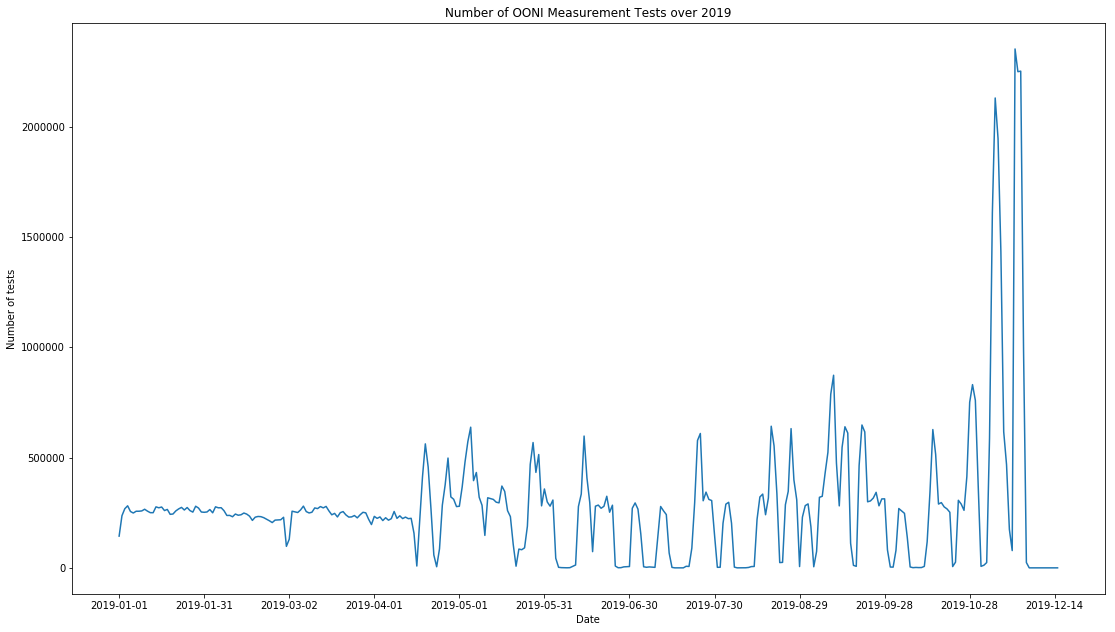

In [48]:
plt.figure(figsize=(18.5, 10.5))

date_counts_2019.reset_index(inplace = True)
plt.plot(date_counts_2019["measurement_start_date"], date_counts_2019["num_measurements"])
plt.xticks(date_counts_2019["measurement_start_date"][::30])

plt.title("Number of OONI Measurement Tests over 2019")
plt.xlabel("Date")
plt.ylabel("Number of tests")

plt.show()

In [49]:
date_counts_2019.to_csv("date_counts/2019/date_counts_2019_full")

## Measurements by Day and Country (2019)

We investigate what could possibly lead to the test number spikes, and which countries appear to be strongly following / influencing the overall trend in number of tests. To do this, we basically repeat the process of writing intermediate files from above, with the only exception being that we group by 2 levels -- measurement_start_date and probe_cc -- instead of one.

In [ ]:
file_num = 12
curr_meas_2019 = measurements_2019_12

reports_2019 = pd.read_csv("reports/reports-2019.csv")
inputs = pd.read_sql_query("SELECT * from input", sql_engine)

meas_2019_joined = curr_meas_2019.merge(reports_2019, on = "report_no", how = "left")
meas_2019_joined = meas_2019_joined.merge(inputs, on = "input_no", how = "left")

In [ ]:
# group by date and country code
meas_2019_joined['measurement_start_date'] = meas_2019_joined['measurement_start_time'].apply(lambda x: x[:10])
meas_2019_date_groups = meas_2019_joined.groupby(["measurement_start_date", "probe_cc"])

meas_2019_date_groups.first()

In [6]:
meas_2019_dates_cc = meas_2019_date_groups.count()[["msm_no"]]
meas_2019_dates_cc.head()

msm_no
measurement_start_date probe_cc        
2019-01-01             AM             7
                       AT            70
                       AU            28
                       BF             7
                       BR           126

In [7]:
meas_2019_dates_cc.rename(columns={"msm_no": "num_measurements"}, inplace = True)
meas_2019_dates_cc.head()

num_measurements
measurement_start_date probe_cc                  
2019-01-01             AM                       7
                       AT                      70
                       AU                      28
                       BF                       7
                       BR                     126

In [8]:
meas_2019_dates_cc.to_csv("date_counts/2019/date_counts_2019_cc_" + str(file_num))

Load all date counts grouped by country code tables into separate dataframes and concatenate them. We can now group by probe_cc and create new dataframes that contain only country-specific information over 2019 dates.

In [9]:
date_counts_2019 = pd.read_csv("date_counts/2019/date_counts_2019_cc_1")

for i in range(2, 13):
    new_dc_df = pd.read_csv("date_counts/2019/date_counts_2019_cc_" + str(i))
    date_counts_2019 = pd.concat([date_counts_2019, new_dc_df], axis = 0, sort = True)

print(len(date_counts_2019))
date_counts_2019.head()

143612


measurement_start_date  num_measurements probe_cc
0             2019-01-01                 3       AE
1             2019-01-01                 2       AF
2             2019-01-01                 1       AL
3             2019-01-01                 5       AP
4             2019-01-01                 9       AR

In [77]:
countries = ["CN", "RU", "US"]

start = datetime.datetime(2019, 1, 1)
end = datetime.datetime(2020, 1, 1)
dates_2019 = [str(x)[:10] for x in pd.date_range(start, end)]

country_counts_2019 = []
for c in countries:
    new_country_count = date_counts_2019.loc[date_counts_2019["probe_cc"] == c].groupby("measurement_start_date").sum()
    new_country_count = new_country_count.reset_index()[["measurement_start_date", "num_measurements"]]
    for d in dates_2019:
        if len(new_country_count.loc[new_country_count["measurement_start_date"] == d]) <= 0:
            new_country_count = new_country_count.append({"measurement_start_date": d, "num_measurements": 0, "probe_cc": c}, ignore_index = True)
    country_counts_2019.append(new_country_count)
    print(len(new_country_count))

366
366
366


Create a plot of overlaid number of test traces by country -- specifically China, Russia, and the U.S. We notice that Russia's mid-October spike in the number of tests taken correlates to a spike in the overall aggregated number of tests plot from above, while China appears to be taking a very small number of tests over time.

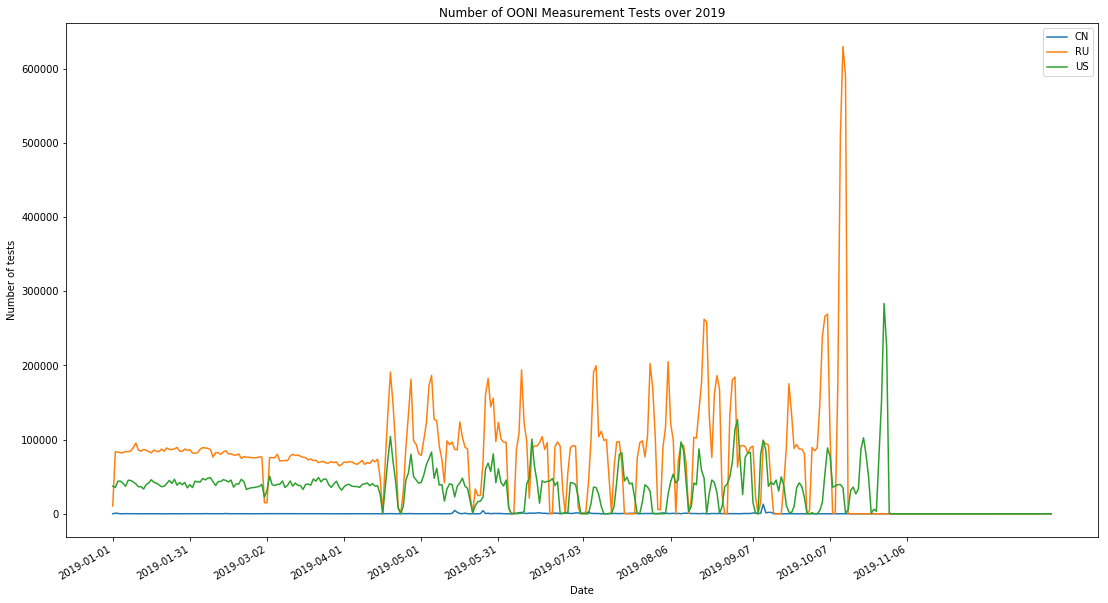

In [78]:
fig = plt.figure(figsize=(18.5, 10.5))

count = 0

for c in country_counts_2019:
    c.reset_index(inplace = True)
    plt.plot(dates_2019, c["num_measurements"], label = countries[count])
    count += 1

plt.xticks(c2["measurement_start_date"][::30])

plt.title("Number of OONI Measurement Tests over 2019")
plt.xlabel("Date")
plt.ylabel("Number of tests")

plt.gcf().autofmt_xdate()

plt.legend()

plt.matplotlib.pyplot.show()

## Confirmed / Anomalous Events by Input and Country

We look deeper into which inputs (also grouped by probe country) lead to the largest number of confirmed or anomalous events. To prevent the kernel from dying, we run code to write grouped input-probe_cc calculations to files.

<b>Note</b>: The variables file_num and curr_meas_2019 = measurements_2019_xx can be changed so file_num = xx -- this setup rather than a for loop was created to prevent the kernel from dying between writes.

In [3]:
file_num = 12
curr_meas_2019 = measurements_2019_12

reports_2019 = pd.read_csv("reports/reports-2019.csv")
inputs = pd.read_sql_query("SELECT * from input", sql_engine)

meas_2019_joined = curr_meas_2019.merge(reports_2019, on = "report_no", how = "left")
meas_2019_joined = meas_2019_joined.merge(inputs, on = "input_no", how = "left")

In [4]:
# group by input, country code, and test name
meas_2019_input_groups = meas_2019_joined.groupby(["input", "probe_cc", "test_name"])

meas_2019_input_groups.first()

Unnamed: 0_x  \
input                         probe_cc test_name                                 
                              EG       http_invalid_request_line         49681   
104.192.5.248:9001            AT       tcp_connect                       69456   
                              AU       tcp_connect                       27101   
                              BR       tcp_connect                       39554   
                              CA       tcp_connect                      110184   
                              CH       tcp_connect                       58035   
                              DE       tcp_connect                       29457   
                              FR       tcp_connect                       12829   
                              GB       tcp_connect                      103387   
                              HK       tcp_connect                       25757   
                              ID       tcp_connect                       71130   
                              JP       tcp_connect                       77829   
                              NG       tcp_connect                      106807   
                              NO       tcp_connect                        2988   
                              PK       tcp_connect                       62818   
                              RO       tcp_connect                       95455   
                              RU       tcp_connect                       15017   
                              TH       tcp_connect                       86984   
                              TR       tcp_connect                       11775   
                              TW       tcp_connect                       89472   
                              US       tcp_connect                        5983   
                              ZW       tcp_connect                      100963   
                              ZZ       tcp_connect                       15223   
104.200.20.46:9001            AU       tcp_connect                       22417   
                              BR       tcp_connect                       24638   
                              CA       tcp_connect                       95346   
                              DE       tcp_connect                          91   
                              FI       tcp_connect                        1869   
                              FR       tcp_connect                       21208   
                              GB       tcp_connect                       13947   
...                                                                        ...   
ooni.nu                       ZZ       tcp_connect                       25901   
scramblesuit 83.212.101.3:443 AT       tcp_connect                       22299   
                              AU       tcp_connect                      109995   
                              BR       tcp_connect                       20222   
                              BY       tcp_connect                       53344   
                              DE       tcp_connect                       39505   
                              FI       tcp_connect                         747   
                              FR       tcp_connect                       28207   
                              GB       tcp_connect                      112331   
                              GR       tcp_connect                      108925   
                              HK       tcp_connect                      103405   
                              IN       tcp_connect                       46835   
                              IT       tcp_connect                       65920   
                              KR       tcp_connect                       63844   
                              MX       tcp_connect                       97634   
                              MY       tcp_connect                       40755   
                              NL       tcp_conne

Sum the confirmed and anomaly columns because their values range from 0-1 based on success / failure, but input_no is counted to keep track of the total number of rows in each input-country-test subgroup.

In [5]:
meas_2019_inputs_cc = meas_2019_input_groups.agg({"confirmed": "sum", "anomaly": "sum", "input_no": "count"})
meas_2019_inputs_cc.head()

confirmed  input_no  \
input              probe_cc test_name                                        
                   EG       http_invalid_request_line          0         7   
104.192.5.248:9001 AT       tcp_connect                        0        14   
                   AU       tcp_connect                        0         7   
                   BR       tcp_connect                        0         7   
                   CA       tcp_connect                        0         7   

                                                       anomaly  
input              probe_cc test_name                           
                   EG       http_invalid_request_line        0  
104.192.5.248:9001 AT       tcp_connect                      0  
                   AU       tcp_connect                      0  
                   BR       tcp_connect                      0  
                   CA       tcp_connect                      0

Rename the columns to more intuitive names based on what they are measuring.

In [6]:
meas_2019_inputs_cc.rename(columns={"input_no": "num_measurements", "confirmed": "num_confirmed", "anomaly": "num_anomaly"}, inplace = True)
meas_2019_inputs_cc.head()

num_confirmed  \
input              probe_cc test_name                                  
                   EG       http_invalid_request_line              0   
104.192.5.248:9001 AT       tcp_connect                            0   
                   AU       tcp_connect                            0   
                   BR       tcp_connect                            0   
                   CA       tcp_connect                            0   

                                                       num_measurements  \
input              probe_cc test_name                                     
                   EG       http_invalid_request_line                 7   
104.192.5.248:9001 AT       tcp_connect                              14   
                   AU       tcp_connect                               7   
                   BR       tcp_connect                               7   
                   CA       tcp_connect                               7   

                                                       num_anomaly  
input              probe_cc test_name                               
                   EG       http_invalid_request_line            0  
104.192.5.248:9001 AT       tcp_connect                          0  
                   AU       tcp_connect                          0  
                   BR       tcp_connect                          0  
                   CA       tcp_connect                          0

Save each intermediate groupby operation to a csv file for later retrieval.

In [7]:
meas_2019_inputs_cc.to_csv("date_counts/2019/input_counts_2019_cc_" + str(file_num))

Load each intermediate dataframe out of its csv file and into an aggregate dataframe with concatenated rows.

In [3]:
input_counts_2019 = pd.read_csv("date_counts/2019/input_counts_2019_cc_1")

for i in range(2, 13):
    new_dc_df = pd.read_csv("date_counts/2019/input_counts_2019_cc_" + str(i))
    input_counts_2019 = pd.concat([input_counts_2019, new_dc_df], axis = 0, sort = True)

print(len(input_counts_2019))

input_counts_2019["num_confirmed"] = pd.to_numeric(input_counts_2019["num_confirmed"], errors='coerce')
input_counts_2019["num_anomaly"] = pd.to_numeric(input_counts_2019["num_anomaly"], errors='coerce')
input_counts_2019["num_measurements"] = pd.to_numeric(input_counts_2019["num_measurements"], errors='coerce')

input_counts_2019.head()

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:3049: DtypeWarning:

Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:3049: DtypeWarning:

Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.



2347478


input  num_anomaly  num_confirmed  num_measurements probe_cc  \
0   NaN          0.0            0.0                 1       AE   
1   NaN          0.0            0.0                 1       CN   
2   NaN          0.0            0.0                 1       DE   
3   NaN          0.0            0.0                 1       ID   
4   NaN          0.0            0.0                 1       IR   

                   test_name  
0  http_invalid_request_line  
1                        ndt  
2                        ndt  
3  http_invalid_request_line  
4                        ndt

Find the rows corresponding to the US (probe_cc). Can we say anything about the measurements and test names people seem to run from this country?

In [4]:
us_inputs_2019 = input_counts_2019.loc[input_counts_2019.probe_cc == "US"]
print(len(us_inputs_2019))
us_inputs_2019.head()

53412


input  num_anomaly  num_confirmed  num_measurements  \
73   104.192.5.248:9001          0.0            0.0               562   
142  104.200.20.46:9001          0.0            0.0               570   
221  108.53.208.157:443          0.0            0.0               567   
287  109.105.109.146:22          0.0            0.0               591   
354  109.105.109.165:22          0.0            0.0               590   

    probe_cc    test_name  
73        US  tcp_connect  
142       US  tcp_connect  
221       US  tcp_connect  
287       US  tcp_connect  
354       US  tcp_connect

We notice that because we haven't grouped the results by test_name yet, we have multiple entries with the same test (from different files), but web connectivity seems to be the most commonly-run test.

In [5]:
us_inputs_2019.sort_values(by = "num_measurements", ascending = False).head()

input  num_anomaly  num_confirmed  \
124951  http://www.netaddress.com/        100.0            0.0   
128450  http://www.netaddress.com/        100.0            0.0   
116977    http://www.linkedin.com/         98.0            0.0   
68172      http://www.bbc.com/news         88.0            0.0   
70558      http://www.bbc.com/news        102.0            0.0   

        num_measurements probe_cc         test_name  
124951              1102       US  web_connectivity  
128450              1062       US  web_connectivity  
116977              1053       US  web_connectivity  
68172               1049       US  web_connectivity  
70558               1044       US  web_connectivity

Create a new column -- test_name_dict -- to keep track of test name counts per country. Eventually some of these cells will have more than one entry and we won't have duplicate rows per country anymore.

In [6]:
input_counts_2019["test_name_dict"] = input_counts_2019.apply(lambda x: {x["test_name"]: x["num_anomaly"]}, axis = 1)
input_counts_2019.loc[(input_counts_2019.probe_cc == "RU") & (input_counts_2019.input == "http://yaltatv.ru")]

input  num_anomaly  num_confirmed  num_measurements  \
167003  http://yaltatv.ru          4.0            4.0                 4   
160973  http://yaltatv.ru          4.0            4.0                 4   
118783  http://yaltatv.ru         10.0           10.0                10   

       probe_cc         test_name              test_name_dict  
167003       RU  web_connectivity   {'web_connectivity': 4.0}  
160973       RU               NaN                  {nan: 4.0}  
118783       RU  web_connectivity  {'web_connectivity': 10.0}

Find all rows for Russia.

In [34]:
ru_inputs_2019 = input_counts_2019.loc[input_counts_2019.probe_cc == "RU"]
print(len(ru_inputs_2019))
ru_inputs_2019.head()

46376


input  num_anomaly  num_confirmed  num_measurements  \
63   104.192.5.248:9001          0.0            0.0              1162   
132  104.200.20.46:9001          0.0            0.0              1172   
211  108.53.208.157:443          0.0            0.0              1174   
277  109.105.109.146:22          0.0            0.0              1159   
344  109.105.109.165:22          0.0            0.0              1217   

    probe_cc    test_name        test_name_dict  
63        RU  tcp_connect  {'tcp_connect': 0.0}  
132       RU  tcp_connect  {'tcp_connect': 0.0}  
211       RU  tcp_connect  {'tcp_connect': 0.0}  
277       RU  tcp_connect  {'tcp_connect': 0.0}  
344       RU  tcp_connect  {'tcp_connect': 0.0}

Write a function that when passed in a Pandas series object, will be able to convert it into a dictionary with each key being a unique value in the series and each value being its count.

In [7]:
def agg_test_name(series):
    d_all = {}
    for d in series:
        if list(d.values())[0] == 0:
            continue
        d_all.update(d)
    return d_all

Apply aggregating functions to each relevant column as mentioned earlier (to keep track of confirmed, anomaly, total measurements), but all apply agg_test_name to test_name_dict so each row has a dictionary where each entry is a unique test name and the value is its count.

In [38]:
ru_inputs_2019 = ru_inputs_2019.groupby(["input", "probe_cc"]).agg({"num_confirmed": "sum", "num_anomaly": "sum", "num_measurements": "sum", "test_name_dict": lambda x: agg_test_name(x)})
ru_inputs_2019.head(20)

num_confirmed  num_measurements  num_anomaly  \
input                probe_cc                                                 
104.192.5.248:9001   RU                  0.0             12993          0.0   
104.200.20.46:9001   RU                  0.0             13123          0.0   
108.53.208.157:443   RU                  0.0             13063          0.0   
109.105.109.146:22   RU                  0.0             13478          0.0   
109.105.109.165:22   RU                  0.0             13427          0.0   
128.199.55.207:9001  RU                  0.0             12965          0.0   
128.31.0.34:9101     RU                  0.0              5154          0.0   
128.31.0.34:9131     RU                  0.0              5154          0.0   
128.31.0.39:9101     RU                  0.0             13322          0.0   
128.31.0.39:9131     RU                  0.0             13197          0.0   
131.188.40.189:443   RU                  0.0             13301          0.0   
131.188.40.189:80    RU                  0.0             13240          0.0   
134.119.36.135:443   RU                  0.0             13163          0.0   
136.243.214.137:443  RU                  0.0             13064          0.0   
138.201.250.33:9011  RU                  0.0             13026          0.0   
146.185.177.103:9030 RU                  0.0             13095          0.0   
149.56.141.138:9001  RU                  0.0             12919          0.0   
149.56.45.200:9001   RU                  0.0             12971          0.0   
151.80.42.103:9001   RU                  0.0             12941          0.0   
154.35.175.225:443   RU                  0.0             13232          0.0   

                              test_name_dict  
input                probe_cc                 
104.192.5.248:9001   RU                   {}  
104.200.20.46:9001   RU                   {}  
108.53.208.157:443   RU                   {}  
109.105.109.146:22   RU                   {}  
109.105.109.165:22   RU                   {}  
128.199.55.207:9001  RU                   {}  
128.31.0.34:9101     RU                   {}  
128.31.0.34:9131     RU                   {}  
128.31.0.39:9101     RU                   {}  
128.31.0.39:9131     RU                   {}  
131.188.40.189:443   RU                   {}  
131.188.40.189:80    RU                   {}  
134.119.36.135:443   RU                   {}  
136.243.214.137:443  RU                   {}  
138.201.250.33:9011  RU                   {}  
146.185.177.103:9030 RU                   {}  
149.56.141.138:9001  RU                   {}  
149.56.45.200:9001   RU                   {}  
151.80.42.103:9001   RU                   {}  
154.35.175.225:443   RU                   {}

The below are the 5 most commonly failed ("confirmed") websites in Russia. We notice that many rows have a test_name_dict with a nan entry, indicating that some measurements don't fall into the regular categorization of tests. (There may be another way to calculate with this -- I ignored these nans for the most part)

In [39]:
ru_inputs_2019.sort_values(by = "num_confirmed", ascending = False).head()

num_confirmed  num_measurements  \
input                       probe_cc                                    
http://drugs-forum.com/     RU               5717.0             13683   
http://www.youporn.com/     RU               5652.0             13556   
http://www.seedoff.tv/      RU               5631.0             13111   
http://www.ej.ru/           RU               5607.0             12861   
http://www.blackseango.org/ RU               5592.0             12915   

                                      num_anomaly  \
input                       probe_cc                
http://drugs-forum.com/     RU            13291.0   
http://www.youporn.com/     RU            13119.0   
http://www.seedoff.tv/      RU            11351.0   
http://www.ej.ru/           RU            11307.0   
http://www.blackseango.org/ RU            10949.0   

                                                                test_name_dict  
input                       probe_cc                                            
http://drugs-forum.com/     RU         {nan: 1187.0, 'web_connectivity': 77.0}  
http://www.youporn.com/     RU        {nan: 1143.0, 'web_connectivity': 126.0}  
http://www.seedoff.tv/      RU         {nan: 952.0, 'web_connectivity': 210.0}  
http://www.ej.ru/           RU          {nan: 971.0, 'web_connectivity': 91.0}  
http://www.blackseango.org/ RU          {nan: 945.0, 'web_connectivity': 91.0}

Calculate strict and loose rates per website in Russia.

In [40]:
ru_inputs_2019["strict_rate"] = ru_inputs_2019["num_confirmed"] / ru_inputs_2019["num_measurements"]
ru_inputs_2019["loose_rate"] = (ru_inputs_2019["num_confirmed"] + ru_inputs_2019["num_anomaly"]) / ru_inputs_2019["num_measurements"]
ru_inputs_2019.head()

num_confirmed  num_measurements  num_anomaly  \
input              probe_cc                                                 
104.192.5.248:9001 RU                  0.0             12993          0.0   
104.200.20.46:9001 RU                  0.0             13123          0.0   
108.53.208.157:443 RU                  0.0             13063          0.0   
109.105.109.146:22 RU                  0.0             13478          0.0   
109.105.109.165:22 RU                  0.0             13427          0.0   

                            test_name_dict  strict_rate  loose_rate  
input              probe_cc                                          
104.192.5.248:9001 RU                   {}          0.0         0.0  
104.200.20.46:9001 RU                   {}          0.0         0.0  
108.53.208.157:443 RU                   {}          0.0         0.0  
109.105.109.146:22 RU                   {}          0.0         0.0  
109.105.109.165:22 RU                   {}          0.0         0.0

<b>Note</b>: An interesting thing I found here is that the loose rate appears to be larger than expected because in some cases, num_confirmed + num_anomaly >= num_measurements. In this case, the rate won't come out fractional. A possible cause is that the number of anomaly events actually includes the number of confirmed events. Something to think about -- do we want to move forward with a possible loose rate as a metric in the case that it double-counts confirmed events?

In [41]:
ru_inputs_2019.sort_values(by = "strict_rate", ascending = False).head(10)

num_confirmed  \
input                                              probe_cc                  
http://yaltatv.ru                                  RU                 18.0   
https://82.rkn.gov.ru/                             RU                 18.0   
http://rkn.gov.ru/                                 RU                 18.0   
http://utronews.org                                RU                  3.0   
http://antikor.com.ua/articles/48244-o_chastyh_... RU                  2.0   
http://sled.net.ua/                                RU                 36.0   
http://www.narkop.com/                             RU               2223.0   
http://www.russiancasino.com/                      RU               2222.0   
http://www.seedjah.com/                            RU               2226.0   
http://kavkaznews.com/                             RU               2223.0   

                                                             num_measurements  \
input                                              probe_cc                     
http://yaltatv.ru                                  RU                      18   
https://82.rkn.gov.ru/                             RU                      18   
http://rkn.gov.ru/                                 RU                      18   
http://utronews.org                                RU                       4   
http://antikor.com.ua/articles/48244-o_chastyh_... RU                       3   
http://sled.net.ua/                                RU                      78   
http://www.narkop.com/                             RU                    5075   
http://www.russiancasino.com/                      RU                    5080   
http://www.seedjah.com/                            RU                    5093   
http://kavkaznews.com/                             RU                    5093   

                                                             num_anomaly  \
input                                              probe_cc                
http://yaltatv.ru                                  RU               18.0   
https://82.rkn.gov.ru/                             RU               18.0   
http://rkn.gov.ru/                                 RU               18.0   
http://utronews.org                                RU                3.0   
http://antikor.com.ua/articles/48244-o_chastyh_... RU                2.0   
http://sled.net.ua/                                RU               67.0   
http://www.narkop.com/                             RU             4517.0   
http://www.russiancasino.com/                      RU             4531.0   
http://www.seedjah.com/                            RU             4132.0   
http://kavkaznews.com/                             RU             4148.0   

                                                                                      test_name_dict  \
input                                              probe_cc                                            
http://yaltatv.ru                                  RU           {nan: 4.0, 'web_connectivity': 10.0}   
https://82.rkn.gov.ru/                             RU           {nan: 4.0, 'web_connectivity': 10.0}   
http://rkn.gov.ru/                                 RU           {nan: 4.0, 'web_connectivity': 10.0}   
http://utronews.org                                RU                      {'web_connectivity': 3.0}   
http://antikor.com.ua/articles/48244-o_chastyh_... RU                      {'web_connectivity': nan}   
http://sled.net.ua/                                RU           {nan: 3.0, 'web_connectivity': 11.0}   
http://www.narkop.com/                             RU        {nan: 518.0, 'web_connectivity': 806.0}   
http://www.russiancasino.com/                      RU        {nan: 530.0, 'web_connectivity': 811.0}   
http://www.seedjah.com/                            RU        {nan: 480.0, 'web_connectivity': 743.0}   
http://kavkaznews.com/                             RU        {nan: 476.0, 'web_connectivity': 

Let's repeat this process on multiple countries -- the US, China, Saudi Arabia, Russia, Ukraine, and Romania. These are the countries with the most "interesting" strict rate behavior in 2019, with the exception of the US, which we will use as a baseline.

The first table printed per country includes all calculations per input per country ranked by strict rate, and the second is the same, ranked by loose rate.

In [9]:
countries = ["US", "CN", "SA", "RU", "UA", "RO"]
country_input_dfs = {}

for c in countries:
    curr_inputs_2019 = input_counts_2019.loc[input_counts_2019.probe_cc == c]
    curr_inputs_2019 = ru_inputs_2019 = curr_inputs_2019.groupby(["input", "probe_cc"]).agg({"num_confirmed": "sum", "num_anomaly": "sum", "num_measurements": "sum", "test_name_dict": lambda x: agg_test_name(x)})
    curr_inputs_2019["strict_rate"] = curr_inputs_2019["num_confirmed"] / curr_inputs_2019["num_measurements"]
    curr_inputs_2019["loose_rate"] = (curr_inputs_2019["num_confirmed"] + curr_inputs_2019["num_anomaly"]) / curr_inputs_2019["num_measurements"]
    country_input_dfs[c] = curr_inputs_2019
    print(c)
    display(curr_inputs_2019.sort_values(by = "strict_rate", ascending = False).head(10))
    display(curr_inputs_2019.sort_values(by = "loose_rate", ascending = False).head(10))
    print()

US


num_measurements  \
input                                              probe_cc                     
104.18.32.66:80                                    US                       2   
http://www.savethechildren.net/                    US                    3071   
http://www.savefrom.net                            US                       3   
http://www.satp.org/satporgtp/site.htm             US                      10   
http://www.satp.org/                               US                    2662   
http://www.satp.org                                US                    4041   
http://www.sandeepweb.com/2012/08/11/the-ongoin... US                       2   
http://www.samsung.com                             US                       2   
http://www.samsclub.com                            US                       4   
http://www.samesexmarriage.ca/                     US                    2732   

                                                             num_confirmed  \
input                                              probe_cc                  
104.18.32.66:80                                    US                  0.0   
http://www.savethechildren.net/                    US                  0.0   
http://www.savefrom.net                            US                  0.0   
http://www.satp.org/satporgtp/site.htm             US                  0.0   
http://www.satp.org/                               US                  0.0   
http://www.satp.org                                US                  0.0   
http://www.sandeepweb.com/2012/08/11/the-ongoin... US                  0.0   
http://www.samsung.com                             US                  0.0   
http://www.samsclub.com                            US                  0.0   
http://www.samesexmarriage.ca/                     US                  0.0   

                                                                                    test_name_dict  \
input                                              probe_cc                                          
104.18.32.66:80                                    US                                           {}   
http://www.savethechildren.net/                    US                    {'web_connectivity': 2.0}   
http://www.savefrom.net                            US                                           {}   
http://www.satp.org/satporgtp/site.htm             US                                           {}   
http://www.satp.org/                               US        {nan: 45.0, 'web_connectivity': 48.0}   
http://www.satp.org                                US        {nan: 37.0, 'web_connectivity': 14.0}   
http://www.sandeepweb.com/2012/08/11/the-ongoin... US                                           {}   
http://www.samsung.com                             US                                           {}   
http://www.samsclub.com                            US                                           {}   
http://www.samesexmarriage.ca/                     US        {nan: 44.0, 'web_connectivity': 48.0}   

                                                             num_anomaly  \
input                                              probe_cc                
104.18.32.66:80                                    US                0.0   
http://www.savethechildren.net/                    US                4.0   
http://www.savefrom.net                            US                0.0   
http://www.satp.org/satporgtp/site.htm             US                0.0   
http://www.satp.org/                               US              347.0   
http://www.satp.org                                US              575.0   
http://www.sandeepweb.com/2012/08/11/the-ongoin... US                0.0   
http://www.samsung.com                             US                0.0   
http://www.samsclub.com                            US                0.0   
http://www.samesexmarriage.ca/                     US              352.0   

             

num_measurements  num_confirmed  \
input                               probe_cc                                    
https://kinox.to/                   US                       2            0.0   
http://www.kayhanlondon.com/        US                       2            0.0   
http://www.shurideh.com/            US                       4            0.0   
http://www.fieldnation.com          US                       2            0.0   
http://178.128.183.175              US                       7            0.0   
http://aporrea.org                  US                       2            0.0   
http://165.227.22.116               US                       5            0.0   
http://aqueeerdiaries.blogspot.com/ US                       4            0.0   
http://www.soberania.org            US                       2            0.0   
http://www.azadegy.de/              US                       3            0.0   

                                                         test_name_dict  \
input                               probe_cc                              
https://kinox.to/                   US        {'web_connectivity': 2.0}   
http://www.kayhanlondon.com/        US        {'web_connectivity': 2.0}   
http://www.shurideh.com/            US        {'web_connectivity': 4.0}   
http://www.fieldnation.com          US                       {nan: 2.0}   
http://178.128.183.175              US        {'web_connectivity': 4.0}   
http://aporrea.org                  US        {'web_connectivity': 2.0}   
http://165.227.22.116               US        {'web_connectivity': 3.0}   
http://aqueeerdiaries.blogspot.com/ US        {'web_connectivity': 4.0}   
http://www.soberania.org            US        {'web_connectivity': 2.0}   
http://www.azadegy.de/              US        {'web_connectivity': 3.0}   

                                              num_anomaly  strict_rate  \
input                               probe_cc                             
https://kinox.to/                   US                2.0          0.0   
http://www.kayhanlondon.com/        US                2.0          0.0   
http://www.shurideh.com/            US                4.0          0.0   
http://www.fieldnation.com          US                2.0          0.0   
http://178.128.183.175              US                7.0          0.0   
http://aporrea.org                  US                2.0          0.0   
http://165.227.22.116               US                5.0          0.0   
http://aqueeerdiaries.blogspot.com/ US                4.0          0.0   
http://www.soberania.org            US                2.0          0.0   
http://www.azadegy.de/              US                3.0          0.0   

                                              loose_rate  
input                               probe_cc              
https://kinox.to/                   US               1.0  
http://www.kayhanlondon.com/        US               1.0  
http://www.shurideh.com/            US               1.0  
http://www.fieldnation.com          US               1.0  
http://178.128.183.175              US               1.0  
http://aporrea.org                  US               1.0  
http://165.227.22.116               US               1.0  
http://aqueeerdiaries.blogspot.com/ US               1.0  
http://www.soberania.org            US               1.0  
http://www.azadegy.de/              US               1.0


CN


num_measurements  num_confirmed  \
input                             probe_cc                                    
104.192.5.248:9001                CN                      23            0.0   
http://www.square-enix.com/       CN                      22            0.0   
http://www.speeddater.co.uk/      CN                      16            0.0   
http://www.spinpalace.com         CN                       5            0.0   
http://www.spinpalace.com/        CN                      19            0.0   
http://www.sportingbet.com        CN                       5            0.0   
http://www.sportingbet.com/       CN                       6            0.0   
http://www.sportsinteraction.com  CN                       8            0.0   
http://www.sportsinteraction.com/ CN                      30            0.0   
http://www.spotify.com            CN                      51            0.0   

                                                                 test_name_dict  \
input                             probe_cc                                        
104.192.5.248:9001                CN                                         {}   
http://www.square-enix.com/       CN                                         {}   
http://www.speeddater.co.uk/      CN                                         {}   
http://www.spinpalace.com         CN                                         {}   
http://www.spinpalace.com/        CN                                         {}   
http://www.sportingbet.com        CN                                         {}   
http://www.sportingbet.com/       CN                                         {}   
http://www.sportsinteraction.com  CN        {nan: nan, 'web_connectivity': 3.0}   
http://www.sportsinteraction.com/ CN        {nan: 4.0, 'web_connectivity': 7.0}   
http://www.spotify.com            CN                                         {}   

                                            num_anomaly  strict_rate  \
input                             probe_cc                             
104.192.5.248:9001                CN                0.0          0.0   
http://www.square-enix.com/       CN                0.0          0.0   
http://www.speeddater.co.uk/      CN                0.0          0.0   
http://www.spinpalace.com         CN                0.0          0.0   
http://www.spinpalace.com/        CN                0.0          0.0   
http://www.sportingbet.com        CN                0.0          0.0   
http://www.sportingbet.com/       CN                0.0          0.0   
http://www.sportsinteraction.com  CN                5.0          0.0   
http://www.sportsinteraction.com/ CN               28.0          0.0   
http://www.spotify.com            CN                0.0          0.0   

                                            loose_rate  
input                             probe_cc              
104.192.5.248:9001                CN          0.000000  
http://www.square-enix.com/       CN          0.000000  
http://www.speeddater.co.uk/      CN          0.000000  
http://www.spinpalace.com         CN          0.000000  
http://www.spinpalace.com/        CN          0.000000  
http://www.sportingbet.com        CN          0.000000  
http://www.sportingbet.com/       CN          0.000000  
http://www.sportsinteraction.com  CN          0.625000  
http://www.sportsinteraction.com/ CN          0.933333  
http://www.spotify.com            CN          0.000000

num_measurements  num_confirmed  \
input                           probe_cc                                    
https://gcr.io                  CN                       2            0.0   
https://de.m.wikipedia.org      CN                       2            0.0   
https://fr.m.wikipedia.org/     CN                       2            0.0   
http://www.tiananmenmother.org/ CN                      93            0.0   
http://savetibet.us/            CN                      91            0.0   
http://sci-hub.bz/              CN                      17            0.0   
https://www.wikipedia.org       CN                       2            0.0   
http://www.lovoo.com/           CN                      10            0.0   
http://www.rfi.fr               CN                       6            0.0   
https://ca.wikipedia.org        CN                       2            0.0   

                                                                 test_name_dict  \
input                           probe_cc                                          
https://gcr.io                  CN                    {'web_connectivity': 2.0}   
https://de.m.wikipedia.org      CN                    {'web_connectivity': 2.0}   
https://fr.m.wikipedia.org/     CN                    {'web_connectivity': 2.0}   
http://www.tiananmenmother.org/ CN        {nan: 10.0, 'web_connectivity': 16.0}   
http://savetibet.us/            CN        {nan: 11.0, 'web_connectivity': 16.0}   
http://sci-hub.bz/              CN          {nan: 3.0, 'web_connectivity': 5.0}   
https://www.wikipedia.org       CN                    {'web_connectivity': 2.0}   
http://www.lovoo.com/           CN          {nan: 2.0, 'web_connectivity': 5.0}   
http://www.rfi.fr               CN                    {'web_connectivity': 2.0}   
https://ca.wikipedia.org        CN                    {'web_connectivity': 2.0}   

                                          num_anomaly  strict_rate  loose_rate  
input                           probe_cc                                        
https://gcr.io                  CN                2.0          0.0         1.0  
https://de.m.wikipedia.org      CN                2.0          0.0         1.0  
https://fr.m.wikipedia.org/     CN                2.0          0.0         1.0  
http://www.tiananmenmother.org/ CN               93.0          0.0         1.0  
http://savetibet.us/            CN               91.0          0.0         1.0  
http://sci-hub.bz/              CN               17.0          0.0         1.0  
https://www.wikipedia.org       CN                2.0          0.0         1.0  
http://www.lovoo.com/           CN               10.0          0.0         1.0  
http://www.rfi.fr               CN                6.0          0.0         1.0  
https://ca.wikipedia.org        CN                2.0          0.0         1.0


SA


num_measurements  num_confirmed  \
input                             probe_cc                                    
http://bravotube.net              SA                       2            2.0   
http://www.tsroadmap.com          SA                       2            2.0   
http://answering-islam.org/       SA                       4            4.0   
http://www.rollitup.org/          SA                      12           12.0   
http://www.clubdicecasino.com     SA                       2            2.0   
http://avaaz.org                  SA                       2            2.0   
http://www.ultimate-anonymity.com SA                       2            2.0   
http://www.altpenis.com           SA                       2            2.0   
http://howtogrowmarijuana.com     SA                       2            2.0   
http://www.samesexmarriage.ca     SA                       2            2.0   

                                                                 test_name_dict  \
input                             probe_cc                                        
http://bravotube.net              SA                  {'web_connectivity': 2.0}   
http://www.tsroadmap.com          SA                  {'web_connectivity': 2.0}   
http://answering-islam.org/       SA                  {'web_connectivity': 4.0}   
http://www.rollitup.org/          SA        {nan: 2.0, 'web_connectivity': 2.0}   
http://www.clubdicecasino.com     SA                  {'web_connectivity': 2.0}   
http://avaaz.org                  SA                  {'web_connectivity': 2.0}   
http://www.ultimate-anonymity.com SA                  {'web_connectivity': 2.0}   
http://www.altpenis.com           SA                  {'web_connectivity': 2.0}   
http://howtogrowmarijuana.com     SA                  {'web_connectivity': 2.0}   
http://www.samesexmarriage.ca     SA                  {'web_connectivity': 2.0}   

                                            num_anomaly  strict_rate  \
input                             probe_cc                             
http://bravotube.net              SA                2.0          1.0   
http://www.tsroadmap.com          SA                2.0          1.0   
http://answering-islam.org/       SA                4.0          1.0   
http://www.rollitup.org/          SA               12.0          1.0   
http://www.clubdicecasino.com     SA                2.0          1.0   
http://avaaz.org                  SA                2.0          1.0   
http://www.ultimate-anonymity.com SA                2.0          1.0   
http://www.altpenis.com           SA                2.0          1.0   
http://howtogrowmarijuana.com     SA                2.0          1.0   
http://www.samesexmarriage.ca     SA                2.0          1.0   

                                            loose_rate  
input                             probe_cc              
http://bravotube.net              SA               2.0  
http://www.tsroadmap.com          SA               2.0  
http://answering-islam.org/       SA               2.0  
http://www.rollitup.org/          SA               2.0  
http://www.clubdicecasino.com     SA               2.0  
http://avaaz.org                  SA               2.0  
http://www.ultimate-anonymity.com SA               2.0  
http://www.altpenis.com           SA               2.0  
http://howtogrowmarijuana.com     SA               2.0  
http://www.samesexmarriage.ca     SA               2.0

num_measurements  num_confirmed  \
input                              probe_cc                                    
http://www.goldenrivieracasino.com SA                       2            2.0   
http://www.spinpalace.com          SA                       3            3.0   
http://ultrasurf.us                SA                       2            2.0   
http://answering-islam.org/        SA                       4            4.0   
http://www.thegailygrind.com/      SA                      13           13.0   
http://www.aljazeera.net           SA                       3            3.0   
http://www.tsroadmap.com           SA                       2            2.0   
http://www.ultimate-anonymity.com  SA                       2            2.0   
http://avaaz.org                   SA                       2            2.0   
http://www.altpenis.com            SA                       2            2.0   

                                                                  test_name_dict  \
input                              probe_cc                                        
http://www.goldenrivieracasino.com SA                  {'web_connectivity': 2.0}   
http://www.spinpalace.com          SA                  {'web_connectivity': 3.0}   
http://ultrasurf.us                SA                  {'web_connectivity': 2.0}   
http://answering-islam.org/        SA                  {'web_connectivity': 4.0}   
http://www.thegailygrind.com/      SA        {nan: 2.0, 'web_connectivity': 5.0}   
http://www.aljazeera.net           SA                  {'web_connectivity': 3.0}   
http://www.tsroadmap.com           SA                  {'web_connectivity': 2.0}   
http://www.ultimate-anonymity.com  SA                  {'web_connectivity': 2.0}   
http://avaaz.org                   SA                  {'web_connectivity': 2.0}   
http://www.altpenis.com            SA                  {'web_connectivity': 2.0}   

                                             num_anomaly  strict_rate  \
input                              probe_cc                             
http://www.goldenrivieracasino.com SA                2.0          1.0   
http://www.spinpalace.com          SA                3.0          1.0   
http://ultrasurf.us                SA                2.0          1.0   
http://answering-islam.org/        SA                4.0          1.0   
http://www.thegailygrind.com/      SA               13.0          1.0   
http://www.aljazeera.net           SA                3.0          1.0   
http://www.tsroadmap.com           SA                2.0          1.0   
http://www.ultimate-anonymity.com  SA                2.0          1.0   
http://avaaz.org                   SA                2.0          1.0   
http://www.altpenis.com            SA                2.0          1.0   

                                             loose_rate  
input                              probe_cc              
http://www.goldenrivieracasino.com SA               2.0  
http://www.spinpalace.com          SA               2.0  
http://ultrasurf.us                SA               2.0  
http://answering-islam.org/        SA               2.0  
http://www.thegailygrind.com/      SA               2.0  
http://www.aljazeera.net           SA               2.0  
http://www.tsroadmap.com           SA               2.0  
http://www.ultimate-anonymity.com  SA               2.0  
http://avaaz.org                   SA               2.0  
http://www.altpenis.com            SA               2.0


RU


num_measurements  \
input                                              probe_cc                     
http://yaltatv.ru                                  RU                      18   
https://82.rkn.gov.ru/                             RU                      18   
http://rkn.gov.ru/                                 RU                      18   
http://utronews.org                                RU                       4   
http://antikor.com.ua/articles/48244-o_chastyh_... RU                       3   
http://sled.net.ua/                                RU                      78   
http://www.narkop.com/                             RU                    5075   
http://www.russiancasino.com/                      RU                    5080   
http://www.seedjah.com/                            RU                    5093   
http://kavkaznews.com/                             RU                    5093   

                                                             num_confirmed  \
input                                              probe_cc                  
http://yaltatv.ru                                  RU                 18.0   
https://82.rkn.gov.ru/                             RU                 18.0   
http://rkn.gov.ru/                                 RU                 18.0   
http://utronews.org                                RU                  3.0   
http://antikor.com.ua/articles/48244-o_chastyh_... RU                  2.0   
http://sled.net.ua/                                RU                 36.0   
http://www.narkop.com/                             RU               2223.0   
http://www.russiancasino.com/                      RU               2222.0   
http://www.seedjah.com/                            RU               2226.0   
http://kavkaznews.com/                             RU               2223.0   

                                                                                      test_name_dict  \
input                                              probe_cc                                            
http://yaltatv.ru                                  RU           {nan: 4.0, 'web_connectivity': 10.0}   
https://82.rkn.gov.ru/                             RU           {nan: 4.0, 'web_connectivity': 10.0}   
http://rkn.gov.ru/                                 RU           {nan: 4.0, 'web_connectivity': 10.0}   
http://utronews.org                                RU                      {'web_connectivity': 3.0}   
http://antikor.com.ua/articles/48244-o_chastyh_... RU                      {'web_connectivity': nan}   
http://sled.net.ua/                                RU           {nan: 3.0, 'web_connectivity': 11.0}   
http://www.narkop.com/                             RU        {nan: 518.0, 'web_connectivity': 806.0}   
http://www.russiancasino.com/                      RU        {nan: 530.0, 'web_connectivity': 811.0}   
http://www.seedjah.com/                            RU        {nan: 480.0, 'web_connectivity': 743.0}   
http://kavkaznews.com/                             RU        {nan: 476.0, 'web_connectivity': 761.0}   

                                                             num_anomaly  \
input                                              probe_cc                
http://yaltatv.ru                                  RU               18.0   
https://82.rkn.gov.ru/                             RU               18.0   
http://rkn.gov.ru/                                 RU               18.0   
http://utronews.org                                RU                3.0   
http://antikor.com.ua/articles/48244-o_chastyh_... RU                2.0   
http://sled.net.ua/                                RU               67.0   
http://www.narkop.com/                             RU             4517.0   
http://www.russiancasino.com/                      RU             4531.0   
http://www.seedjah.com/                            RU             4132.0   
http://kavkaznews.com/                             RU             

num_measurements  num_confirmed  \
input                        probe_cc                                    
http://rkn.gov.ru/           RU                      18           18.0   
https://82.rkn.gov.ru/       RU                      18           18.0   
http://yaltatv.ru            RU                      18           18.0   
http://utronews.org          RU                       4            3.0   
http://azartplay.com/        RU                    5129         2230.0   
http://betway.com/           RU                    5139         2212.0   
http://www.europacasino.com/ RU                    5323         2262.0   
http://www.grani.ru/         RU                    5084         2211.0   
http://www.ichkeria.info/    RU                    5081         2204.0   
http://www.dailymotion.com/  RU                    5317         2281.0   

                                                                 test_name_dict  \
input                        probe_cc                                             
http://rkn.gov.ru/           RU            {nan: 4.0, 'web_connectivity': 10.0}   
https://82.rkn.gov.ru/       RU            {nan: 4.0, 'web_connectivity': 10.0}   
http://yaltatv.ru            RU            {nan: 4.0, 'web_connectivity': 10.0}   
http://utronews.org          RU                       {'web_connectivity': 3.0}   
http://azartplay.com/        RU         {nan: 576.0, 'web_connectivity': 885.0}   
http://betway.com/           RU         {nan: 580.0, 'web_connectivity': 898.0}   
http://www.europacasino.com/ RU           {nan: 599.0, 'web_connectivity': 7.0}   
http://www.grani.ru/         RU         {nan: 576.0, 'web_connectivity': 872.0}   
http://www.ichkeria.info/    RU         {nan: 575.0, 'web_connectivity': 877.0}   
http://www.dailymotion.com/  RU        {nan: 604.0, 'web_connectivity': 1005.0}   

                                       num_anomaly  strict_rate  loose_rate  
input                        probe_cc                                        
http://rkn.gov.ru/           RU               18.0     1.000000    2.000000  
https://82.rkn.gov.ru/       RU               18.0     1.000000    2.000000  
http://yaltatv.ru            RU               18.0     1.000000    2.000000  
http://utronews.org          RU                3.0     0.750000    1.500000  
http://azartplay.com/        RU             5086.0     0.434783    1.426399  
http://betway.com/           RU             5110.0     0.430434    1.424791  
http://www.europacasino.com/ RU             5310.0     0.424948    1.422506  
http://www.grani.ru/         RU             5020.0     0.434894    1.422305  
http://www.ichkeria.info/    RU             5017.0     0.433773    1.421177  
http://www.dailymotion.com/  RU             5272.0     0.429001    1.420538


UA


num_measurements  num_confirmed  \
input                              probe_cc                                    
104.192.5.248:9001                 UA                      19            0.0   
http://www.sos-reporters.net/      UA                      13            0.0   
http://www.solicitorsfromhell.com/ UA                      11            0.0   
http://www.solicitorsfromhell.com  UA                      17            0.0   
http://www.softilla.ru/            UA                      11            0.0   
http://www.softilla.ru             UA                      11            0.0   
http://www.socom.mil/              UA                      12            0.0   
http://www.socom.mil               UA                      16            0.0   
http://www.sobytiya.info/          UA                     345            0.0   
http://www.smi.ru/                 UA                      12            0.0   

                                                        test_name_dict  \
input                              probe_cc                              
104.192.5.248:9001                 UA                               {}   
http://www.sos-reporters.net/      UA        {'web_connectivity': nan}   
http://www.solicitorsfromhell.com/ UA                               {}   
http://www.solicitorsfromhell.com  UA        {'web_connectivity': 2.0}   
http://www.softilla.ru/            UA                               {}   
http://www.softilla.ru             UA        {'web_connectivity': nan}   
http://www.socom.mil/              UA                               {}   
http://www.socom.mil               UA        {'web_connectivity': 2.0}   
http://www.sobytiya.info/          UA        {'web_connectivity': 4.0}   
http://www.smi.ru/                 UA                               {}   

                                             num_anomaly  strict_rate  \
input                              probe_cc                             
104.192.5.248:9001                 UA                0.0          0.0   
http://www.sos-reporters.net/      UA                0.0          0.0   
http://www.solicitorsfromhell.com/ UA                0.0          0.0   
http://www.solicitorsfromhell.com  UA                2.0          0.0   
http://www.softilla.ru/            UA                0.0          0.0   
http://www.softilla.ru             UA                0.0          0.0   
http://www.socom.mil/              UA                0.0          0.0   
http://www.socom.mil               UA                2.0          0.0   
http://www.sobytiya.info/          UA               23.0          0.0   
http://www.smi.ru/                 UA                0.0          0.0   

                                             loose_rate  
input                              probe_cc              
104.192.5.248:9001                 UA          0.000000  
http://www.sos-reporters.net/      UA          0.000000  
http://www.solicitorsfromhell.com/ UA          0.000000  
http://www.solicitorsfromhell.com  UA          0.117647  
http://www.softilla.ru/            UA          0.000000  
http://www.softilla.ru             UA          0.000000  
http://www.socom.mil/              UA          0.000000  
http://www.socom.mil               UA          0.125000  
http://www.sobytiya.info/          UA          0.066667  
http://www.smi.ru/                 UA          0.000000

num_measurements  \
input                                              probe_cc                     
http://www.freetranslation.com/                    UA                       2   
http://www.mail.com/                               UA                       2   
http://sourceforge.net/                            UA                       2   
http://video.google.com                            UA                       2   
http://www.fotki.com/                              UA                       2   
http://www.skype.com/                              UA                       2   
http://www.un.int/                                 UA                       2   
http://support.therapytribe.com/hivaids-support... UA                       2   
https://gknslnr.su/                                UA                      82   
http://www.dating.com/                             UA                       2   

                                                             num_confirmed  \
input                                              probe_cc                  
http://www.freetranslation.com/                    UA                  0.0   
http://www.mail.com/                               UA                  0.0   
http://sourceforge.net/                            UA                  0.0   
http://video.google.com                            UA                  0.0   
http://www.fotki.com/                              UA                  0.0   
http://www.skype.com/                              UA                  0.0   
http://www.un.int/                                 UA                  0.0   
http://support.therapytribe.com/hivaids-support... UA                  0.0   
https://gknslnr.su/                                UA                  0.0   
http://www.dating.com/                             UA                  0.0   

                                                                                   test_name_dict  \
input                                              probe_cc                                         
http://www.freetranslation.com/                    UA                   {'web_connectivity': 2.0}   
http://www.mail.com/                               UA                   {'web_connectivity': 2.0}   
http://sourceforge.net/                            UA                   {'web_connectivity': 2.0}   
http://video.google.com                            UA                   {'web_connectivity': 2.0}   
http://www.fotki.com/                              UA                   {'web_connectivity': 2.0}   
http://www.skype.com/                              UA                   {'web_connectivity': 2.0}   
http://www.un.int/                                 UA                   {'web_connectivity': 2.0}   
http://support.therapytribe.com/hivaids-support... UA                   {'web_connectivity': 2.0}   
https://gknslnr.su/                                UA        {nan: 4.0, 'web_connectivity': 14.0}   
http://www.dating.com/                             UA                   {'web_connectivity': 2.0}   

                                                             num_anomaly  \
input                                              probe_cc                
http://www.freetranslation.com/                    UA                2.0   
http://www.mail.com/                               UA                2.0   
http://sourceforge.net/                            UA                2.0   
http://video.google.com                            UA                2.0   
http://www.fotki.com/                              UA                2.0   
http://www.skype.com/                              UA                2.0   
http://www.un.int/                                 UA                2.0   
http://support.therapytribe.com/hivaids-support... UA                2.0   
https://gknslnr.su/                                UA               82.0   
http://www.dating.com/                             UA                2.0   

                         


RO


num_measurements  num_confirmed  \
input                            probe_cc                                    
http://www.europacasino.com      RO                     182          168.0   
http://www.sportsinteraction.com RO                     129          118.0   
http://www.luckynugget.com/      RO                      65           59.0   
http://www.eurogrand.com/        RO                      63           57.0   
http://casino.com                RO                     188          170.0   
http://www.spinpalace.com        RO                     144          130.0   
http://www.eurogrand.com         RO                     158          142.0   
http://www.partypoker.com        RO                     167          150.0   
http://www.grandonline.com       RO                     150          134.0   
http://www.usacasino.com         RO                     137          122.0   

                                                                  test_name_dict  \
input                            probe_cc                                          
http://www.europacasino.com      RO        {nan: 14.0, 'web_connectivity': 14.0}   
http://www.sportsinteraction.com RO          {nan: 9.0, 'web_connectivity': 4.0}   
http://www.luckynugget.com/      RO         {nan: 13.0, 'web_connectivity': 5.0}   
http://www.eurogrand.com/        RO         {nan: 11.0, 'web_connectivity': 6.0}   
http://casino.com                RO          {nan: 8.0, 'web_connectivity': 6.0}   
http://www.spinpalace.com        RO          {nan: 7.0, 'web_connectivity': 3.0}   
http://www.eurogrand.com         RO          {nan: 4.0, 'web_connectivity': 9.0}   
http://www.partypoker.com        RO         {nan: 13.0, 'web_connectivity': 5.0}   
http://www.grandonline.com       RO          {nan: 7.0, 'web_connectivity': 3.0}   
http://www.usacasino.com         RO          {nan: 4.0, 'web_connectivity': 7.0}   

                                           num_anomaly  strict_rate  \
input                            probe_cc                             
http://www.europacasino.com      RO              170.0     0.923077   
http://www.sportsinteraction.com RO              120.0     0.914729   
http://www.luckynugget.com/      RO               60.0     0.907692   
http://www.eurogrand.com/        RO               57.0     0.904762   
http://casino.com                RO              173.0     0.904255   
http://www.spinpalace.com        RO              132.0     0.902778   
http://www.eurogrand.com         RO              143.0     0.898734   
http://www.partypoker.com        RO              154.0     0.898204   
http://www.grandonline.com       RO              139.0     0.893333   
http://www.usacasino.com         RO              124.0     0.890511   

                                           loose_rate  
input                            probe_cc              
http://www.europacasino.com      RO          1.857143  
http://www.sportsinteraction.com RO          1.844961  
http://www.luckynugget.com/      RO          1.830769  
http://www.eurogrand.com/        RO          1.809524  
http://casino.com                RO          1.824468  
http://www.spinpalace.com        RO          1.819444  
http://www.eurogrand.com         RO          1.803797  
http://www.partypoker.com        RO          1.820359  
http://www.grandonline.com       RO          1.820000  
http://www.usacasino.com         RO          1.795620

num_measurements  num_confirmed  \
input                            probe_cc                                    
http://www.europacasino.com      RO                     182          168.0   
http://www.sportsinteraction.com RO                     129          118.0   
http://www.luckynugget.com/      RO                      65           59.0   
http://casino.com                RO                     188          170.0   
http://www.partypoker.com        RO                     167          150.0   
http://www.grandonline.com       RO                     150          134.0   
http://www.spinpalace.com        RO                     144          130.0   
http://www.eurogrand.com/        RO                      63           57.0   
http://www.eurogrand.com         RO                     158          142.0   
http://www.clubdicecasino.com    RO                     163          145.0   

                                                                  test_name_dict  \
input                            probe_cc                                          
http://www.europacasino.com      RO        {nan: 14.0, 'web_connectivity': 14.0}   
http://www.sportsinteraction.com RO          {nan: 9.0, 'web_connectivity': 4.0}   
http://www.luckynugget.com/      RO         {nan: 13.0, 'web_connectivity': 5.0}   
http://casino.com                RO          {nan: 8.0, 'web_connectivity': 6.0}   
http://www.partypoker.com        RO         {nan: 13.0, 'web_connectivity': 5.0}   
http://www.grandonline.com       RO          {nan: 7.0, 'web_connectivity': 3.0}   
http://www.spinpalace.com        RO          {nan: 7.0, 'web_connectivity': 3.0}   
http://www.eurogrand.com/        RO         {nan: 11.0, 'web_connectivity': 6.0}   
http://www.eurogrand.com         RO          {nan: 4.0, 'web_connectivity': 9.0}   
http://www.clubdicecasino.com    RO         {nan: 12.0, 'web_connectivity': 2.0}   

                                           num_anomaly  strict_rate  \
input                            probe_cc                             
http://www.europacasino.com      RO              170.0     0.923077   
http://www.sportsinteraction.com RO              120.0     0.914729   
http://www.luckynugget.com/      RO               60.0     0.907692   
http://casino.com                RO              173.0     0.904255   
http://www.partypoker.com        RO              154.0     0.898204   
http://www.grandonline.com       RO              139.0     0.893333   
http://www.spinpalace.com        RO              132.0     0.902778   
http://www.eurogrand.com/        RO               57.0     0.904762   
http://www.eurogrand.com         RO              143.0     0.898734   
http://www.clubdicecasino.com    RO              149.0     0.889571   

                                           loose_rate  
input                            probe_cc              
http://www.europacasino.com      RO          1.857143  
http://www.sportsinteraction.com RO          1.844961  
http://www.luckynugget.com/      RO          1.830769  
http://casino.com                RO          1.824468  
http://www.partypoker.com        RO          1.820359  
http://www.grandonline.com       RO          1.820000  
http://www.spinpalace.com        RO          1.819444  
http://www.eurogrand.com/        RO          1.809524  
http://www.eurogrand.com         RO          1.803797  
http://www.clubdicecasino.com    RO          1.803681

Calculate the sum of loose rates per input in the table calculated in the previous cell for Russia. This will help us measure frequencies at which anomalous events occur for particular inputs.

In [7]:
ru_input_df = country_input_dfs["RU"]
ru_input_tuple_dict = ru_input_df['loose_rate'].to_dict()
ru_input_freqs = {}
for k, v in ru_input_tuple_dict.items():
    new_k = k[0]
    if new_k not in ru_input_freqs:
        ru_input_freqs[new_k] = v
    else:
        ru_input_freqs[new_k] += v
list(ru_input_freqs.items())[:10]

[('http://www.opec.org/', 0.0007145409074669524),
 ('http://www.poker.com', 0.0010739856801909309),
 ('http://go-krit.com/workshop', 1.129139573567216),
 ('http://imgur.com/', 0.0),
 ('http://www.dmoz.org/', 0.0010657193605683837),
 ('http://www.baidu.com/', 0.004291845493562232),
 ('http://www.sos-reporters.net', 0.0067106051527860994),
 ('http://www.cbsnews.com/', 0.0005318205991845417),
 ('http://www.frc.org/', 0.0051473198438054665),
 ('http://black.riseup.net/', 0.0078125)]

Repeat the same process as above for China.

In [15]:
cn_input_df = country_input_dfs["CN"]
cn_input_tuple_dict = cn_input_df['loose_rate'].to_dict()
cn_input_freqs = {}
for k, v in cn_input_tuple_dict.items():
    new_k = k[0]
    if new_k not in cn_input_freqs:
        cn_input_freqs[new_k] = v
    else:
        cn_input_freqs[new_k] += v
list(cn_input_freqs.items())[:10]

[('http://www.poker.com', 0.0),
 ('http://www.cbsnews.com/', 0.1111111111111111),
 ('http://imgur.com/', 0.3333333333333333),
 ('http://www.dmoz.org/', 0.0),
 ('http://www.betfair.com', 0.3333333333333333),
 ('http://www.jmarshall.com/tools/cgiproxy/', 0.1111111111111111),
 ('http://www.baidu.com/', 0.0),
 ('http://www.sos-reporters.net', 0.0),
 ('http://www.frc.org/', 0.03333333333333333),
 ('http://black.riseup.net/', 0.9)]

Generate word clouds for Russia and China with each input displayed corresponding to the rate of anomalous events in size i.e. bigger website names have been linked to a higher rate of anomalous activity.

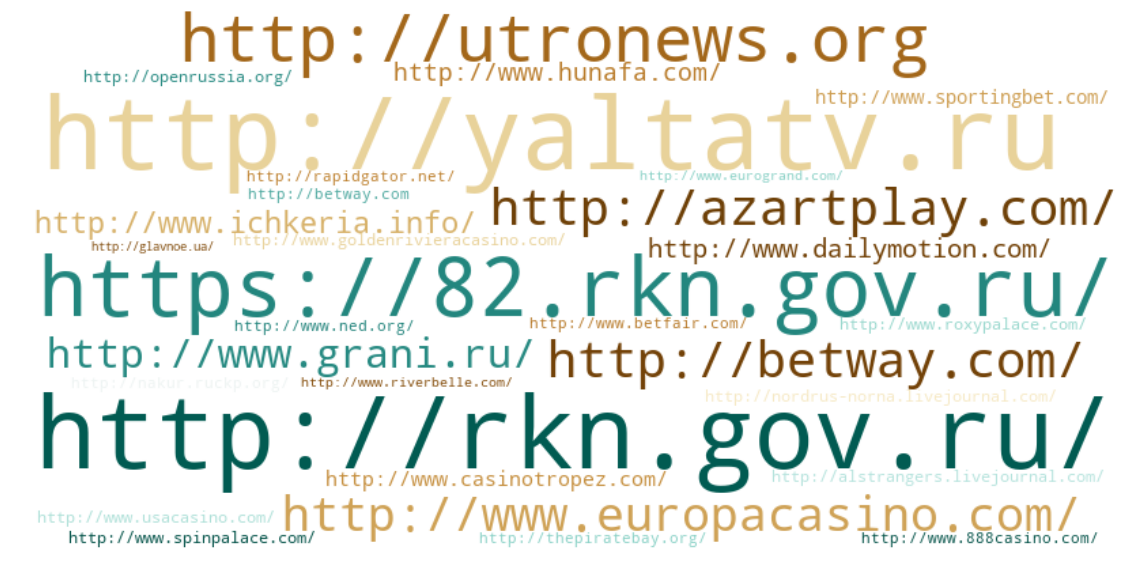

In [33]:
ru_input_wc = WordCloud(width = 800, height = 400, background_color = "white", max_words = 30, colormap = "BrBG").generate_from_frequencies(ru_input_freqs)
plt.figure(figsize = (20,10))
plt.imshow(ru_input_wc, interpolation = 'bilinear')
plt.axis("off")
plt.show()

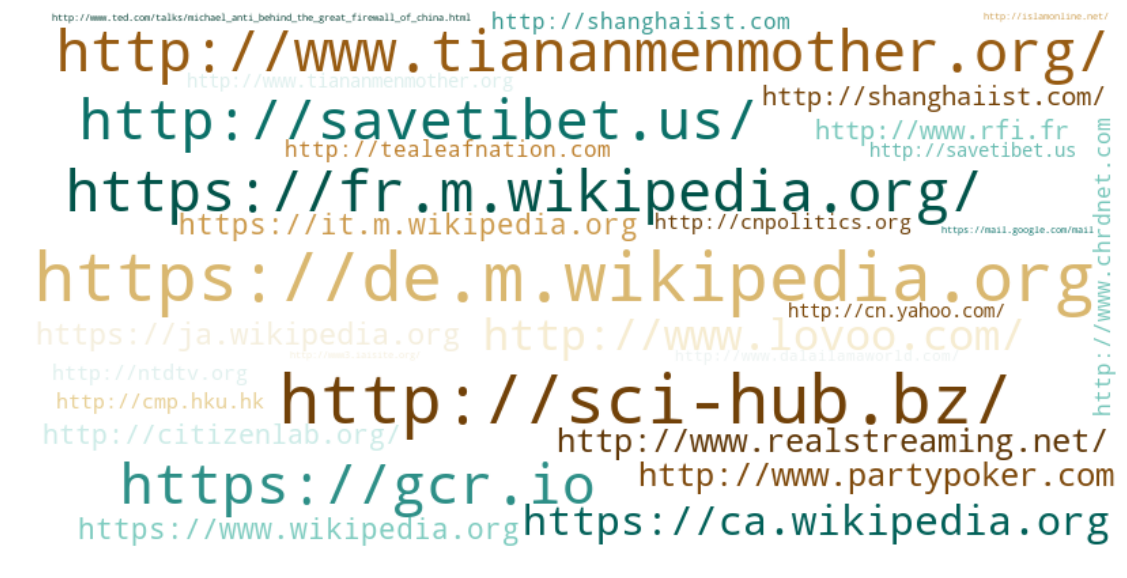

In [34]:
cn_input_wc = WordCloud(width = 800, height = 400, background_color = "white", max_words = 30, colormap = "BrBG").generate_from_frequencies(cn_input_freqs)
plt.figure(figsize = (20,10))
plt.imshow(cn_input_wc, interpolation = 'bilinear')
plt.axis("off")
plt.show()

## Rates by Day and Country

In this section, we will work on developing visualizations that show how our strict and loose rates change over time (specifically, over 2019), and whether we can make really basic predictions of how the rates will change for the rest of the year.

In the first cell, read the current measurements file and join it to the reports table to obtain a probe_cc value for each measurement. Make sure to repeat this process for all measurements files for the year.

In [3]:
file_num = 12
curr_meas_2019 = measurements_2019_12

reports_2019 = pd.read_csv("reports/reports-2019.csv")
inputs = pd.read_sql_query("SELECT * from input", sql_engine)

meas_2019_joined = curr_meas_2019.merge(reports_2019, on = "report_no", how = "left")
meas_2019_joined = meas_2019_joined.merge(inputs, on = "input_no", how = "left")

Group the current joined measurements table by date and country code so we have a data point per country every day (and can then see how these points change over time).

In [4]:
# group by date and country code
meas_2019_joined['measurement_start_date'] = meas_2019_joined['measurement_start_time'].apply(lambda x: x[:10])
meas_2019_date_groups = meas_2019_joined.groupby(["measurement_start_date", "probe_cc"])

meas_2019_date_groups.first()

Unnamed: 0_x     msm_no  report_no  \
measurement_start_date probe_cc                                       
2019-01-01             AM               48914  260139585    7204013   
                       AT                  89  260152262    7205360   
                       AU               48898  260136346    7200774   
                       BF               48924  260151361    7205353   
                       BR                  37  260133172    7200255   
                       BY                  58  260144570    7205183   
                       CA                  19  260128579    7199914   
                       DE                   3  259934233    7198638   
                       EG                 199  260185792    7206261   
                       ET                 136  260167092    7205409   
                       FI                 125  260164156    7205399   
                       FR                   7  260121478    7199887   
                       GB                  42  260140667    7204858   
                       GR                 549  260285636    7206454   
                       HK                 240  260200145    7206386   
                       HR               48919  260141100    7204984   
                       IE                 173  260178546    7205479   
                       IN                  63  260146375    7205213   
                       IT                  33  260132459    7200247   
                       KE                7548  262139583    7258148   
                       KR                  78  260149610    7205241   
                       MA               48911  260138498    7202926   
                       MX                   0  259933268    7198635   
                       MY                 118  260163133    7205396   
                       NL                 123  260163735    7205398   
                       NO                  53  260143243    7205180   
                       PK                  96  260153722    7205365   
                       PL                  20  260129255    7199931   
                       PT               48922  260150103    7205254   
                       RO                 176  260179837    7205633   
...                                       ...        ...        ...   
2019-04-14             IT              119929  291431399    8552161   
                       JP              120009  291451829    8552807   
                       KE              120085  291469818    8560064   
                       KH              120217  291502891    8560178   
                       KR              119168  291240118    8550369   
                       LY              120040  291458981    8557491   
                       MA              120041  291459182    8557692   
                       MX              119178  291243942    8550422   
                       NI              119938  291433030    8552175   
                       NL              119952  291436022    8552198   
                       PK              120399  291550514    8561765   
                       PL              120313  291526944    8561558   
                       PT              120051  291461654    8559424   
                       RO              120195  291497853    8560161   
                       RU              119162  291238365    8550363   
                       SE              119161  291238071    8550362   
                       TH              120651  291610701    8561813   
                       TR              120043  291459644    8558154   
                       TW              119167  291239120    8550366   
                       UA              119931  291431783    8552162   
                       US              119159  291237380    8550360   
                       ZZ              120117  291480353    8560102   
2019-04-15             BE              120236  291508358    8560198   
                       CA              120242  291511034 

Aggregate the columns we need -- sum for confirmed to keep track of the number of confirmed events, sum for anomaly for the number of anomalous events, and count for report_no for the total number of measurements.

In [5]:
meas_2019_dates_events = meas_2019_date_groups.agg({"confirmed": "sum", "anomaly": "sum", "report_no": "count"})
meas_2019_dates_events.head()

report_no  confirmed  anomaly
measurement_start_date probe_cc                               
2019-01-01             AM                7          0        0
                       AT               70          0        0
                       AU               28          0        0
                       BF                7          0        0
                       BR              126          0        7

Rename columns to more intuitive names based on what they're measuring.

In [6]:
meas_2019_dates_events.rename(columns={"report_no": "num_measurements", "confirmed": "num_confirmed", "anomaly": "num_anomaly"}, inplace = True)
meas_2019_dates_events.head()

num_measurements  num_confirmed  num_anomaly
measurement_start_date probe_cc                                              
2019-01-01             AM                       7              0            0
                       AT                      70              0            0
                       AU                      28              0            0
                       BF                       7              0            0
                       BR                     126              0            7

Save the date events dataframe for this measurements file to a csv.

<b>Note</b>: Remember to repeat the steps from the beginning of the section until the cell below to make all intermediate date events calculations for each measurements file.

In [7]:
meas_2019_dates_events.to_csv("date_counts/2019/date_events_2019_cc_" + str(file_num))

Load all date events csv dataframes into an aggregate date_events_2019 dataframe.

The range of the for loop can be changed depending on the number of intermediate files.

In [5]:
date_events_2019 = pd.read_csv("date_counts/2019/date_events_2019_cc_1")

for i in range(2, 13):
    new_de_df = pd.read_csv("date_counts/2019/date_events_2019_cc_" + str(i))
    date_events_2019 = pd.concat([date_events_2019, new_de_df], axis = 0, sort = True)

print(len(date_events_2019))
date_events_2019.head()

143612


measurement_start_date num_anomaly  num_confirmed  num_measurements probe_cc
0             2019-01-01           0              0                 3       AE
1             2019-01-01           0              0                 2       AF
2             2019-01-01           0              0                 1       AL
3             2019-01-01           0              0                 5       AP
4             2019-01-01           0              0                 9       AR

Coerce all relevant columns -- num_confirmed, num_anomaly, num_measurements -- to numeric types.

In [6]:
date_events_2019["num_confirmed"] = pd.to_numeric(date_events_2019["num_confirmed"], errors='coerce')
date_events_2019["num_anomaly"] = pd.to_numeric(date_events_2019["num_anomaly"], errors='coerce')
date_events_2019["num_measurements"] = pd.to_numeric(date_events_2019["num_measurements"], errors='coerce')

Group all Russia rows by measurement start date so we have a num_confirmed, num_anomaly, and num_measurements count for each date there is data for.

In [26]:
ru_rates_2019 = date_events_2019.loc[date_events_2019["probe_cc"] == "RU"].groupby(["measurement_start_date", "probe_cc"]).agg({"num_confirmed": "sum", "num_anomaly": "sum", "num_measurements": "sum"})
ru_rates_2019.head()

num_confirmed  num_anomaly  num_measurements
measurement_start_date probe_cc                                              
2019-01-01             RU                   14       1775.0             10527
2019-01-02             RU                 2264       9717.0             83676
2019-01-03             RU                 2621       8818.0             83150
2019-01-04             RU                 2562       8994.0             82288
2019-01-05             RU                 2622       9158.0             82347

Load in the the end-of-year interference measurements by country into the eoy_interference dataframe. This will be useful when we generate visualizations past the endpoint at which data becomes available.

In [99]:
eoy_interference = pd.read_csv("interference-measurements-by-country-2019-full.csv").sort_values(by = "loose_rate", ascending = False)
eoy_interference.head(20)

country_code  num_confirmed_interference  num_anomaly  \
208           UA                           0      1227714   
172           RE                           0        22383   
32            BY                           0       168942   
152           NL                           0       313423   
31            BW                           0         2206   
91            ID                           0       114273   
40            CL                           0        51574   
153           NO                           2        84527   
58            EG                           0       130291   
95            IN                       13145       330124   
164           PL                           0       107729   
34            CA                           0       457053   
42            CN                           0        22488   
57            EE                           0         4361   
177           SA                        2243         3535   
98            IR                       15504        37274   
28            BR                           0       650763   
50            DE                           0       427834   
161           PG                           0           43   
1             AE                         892         2083   

     num_no_confirmed_interference  strict_rate  loose_rate  
208                        1812228     0.000000    0.677461  
172                          48855     0.000000    0.458152  
32                          446934     0.000000    0.378002  
152                         903163     0.000000    0.347028  
31                            6690     0.000000    0.329746  
91                          384219     0.000000    0.297416  
40                          176066     0.000000    0.292924  
153                         298406     0.000007    0.283267  
58                          469987     0.000000    0.277223  
95                         1245782     0.010441    0.272668  
164                         403656     0.000000    0.266883  
34                         1830192     0.000000    0.249730  
42                           94178     0.000000    0.238782  
57                           21340     0.000000    0.204358  
177                          29165     0.071415    0.183966  
98                          272304     0.053869    0.183379  
28                         3868894     0.000000    0.168204  
50                         2545533     0.000000    0.168072  
161                            258     0.000000    0.166667  
1                            18966     0.044919    0.149814

Specify variables we'll need in the future -- the start and end datetime, the dates for which data is availabe in 2019, and the countries we'll be looking at specifically.

In [8]:
countries = ["UA", "IR", "RU", "CN", "US"]

start = datetime.datetime(2019, 1, 1)
end = datetime.datetime(2020, 1, 1)
dates_2019 = [str(x)[:10] for x in pd.date_range(start, end)]

For each country in the previous cell, we generate a dataframe that contains a cumulative strict rate and a cumulative loose rate, aggregated over all past dates for which data is available in the year. For dates where there is no data, we keep the cumulative rates constant to have an aligned 366 data points per country in the year at the end.

In [9]:
country_rates = {}

for c in countries:
    curr_rates_2019 = date_events_2019.loc[date_events_2019["probe_cc"] == c].groupby(["measurement_start_date", "probe_cc"]).agg({"num_confirmed": "sum", "num_anomaly": "sum", "num_measurements": "sum"})
    
    cumul_confirmed = []
    cumul_anomaly = []
    cumul_meas = []

    evolving_loose_rate = []
    evolving_strict_rate = []

    for i in range(len(curr_rates_2019)):
        curr_row = curr_rates_2019.iloc[i,]

        prev_conf = 0 if len(cumul_confirmed) < 1 else cumul_confirmed[-1]
        prev_ano = 0 if len(cumul_anomaly) < 1 else cumul_anomaly[-1]
        prev_meas = 0 if len(cumul_meas) < 1 else cumul_meas[-1]

        new_conf = curr_row.num_confirmed + prev_conf
        new_ano = curr_row.num_anomaly + prev_ano
        new_meas = curr_row.num_measurements + prev_meas

        cumul_confirmed.append(new_conf)
        cumul_anomaly.append(new_ano)
        cumul_meas.append(new_meas)

        evolving_loose_rate.append((new_conf + new_ano) / new_meas)
        evolving_strict_rate.append(new_conf / new_meas)

    curr_rates_2019["cumul_strict_rate"] = pd.Series(evolving_strict_rate, index = curr_rates_2019.index)
    curr_rates_2019["cumul_loose_rate"] = pd.Series(evolving_loose_rate, index = curr_rates_2019.index)
    
    curr_rates_2019.index = curr_rates_2019.index.droplevel(1)
    
    for d in dates_2019:
        if d not in curr_rates_2019.index:
            new_row = pd.Series({"num_anomaly": 0, "num_confirmed": 0, "num_measurements": 0, "cumul_strict_rate": 0, "cumul_loose_rate": 0}, name = d)
            curr_rates_2019 = curr_rates_2019.append(new_row)
    
    country_rates[c] = curr_rates_2019

print(len(dates_2019))
print(len(country_rates["RU"]))

country_rates["RU"].head()

366
366


num_anomaly  num_measurements  num_confirmed  \
measurement_start_date                                                 
2019-01-01                   1775.0             10527             14   
2019-01-02                   9717.0             83676           2264   
2019-01-03                   8818.0             83150           2621   
2019-01-04                   8994.0             82288           2562   
2019-01-05                   9158.0             82347           2622   

                        cumul_strict_rate  cumul_loose_rate  
measurement_start_date                                       
2019-01-01                       0.001330          0.169944  
2019-01-02                       0.024182          0.146174  
2019-01-03                       0.027623          0.142140  
2019-01-04                       0.028736          0.141599  
2019-01-05                       0.029483          0.141949

In [110]:
print(len(country_rates["CN"]))

country_rates["CN"].head()

366


num_confirmed  num_anomaly  num_measurements  \
measurement_start_date                                                 
2019-01-01                          0          0.0                 9   
2019-01-02                          0        165.0               872   
2019-01-03                          0         21.0               443   
2019-01-04                          0          0.0                36   
2019-01-05                          0          0.0                28   

                        cumul_strict_rate  cumul_loose_rate  
measurement_start_date                                       
2019-01-01                            0.0          0.000000  
2019-01-02                            0.0          0.187287  
2019-01-03                            0.0          0.140483  
2019-01-04                            0.0          0.136765  
2019-01-05                            0.0          0.134006

Plot cumul_strict_rate to see how the cumulative strict rates for the countries RU, CN, UA, US, and IR change over time.

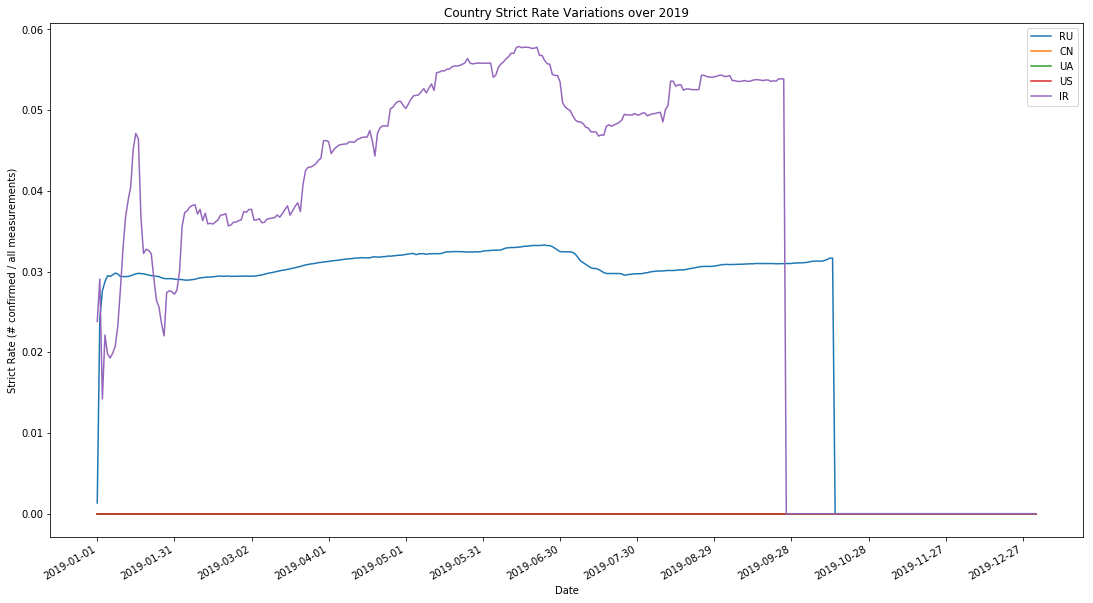

In [15]:
fig = plt.figure(figsize=(18.5, 10.5))

for c in list(country_rates.items()):
    plt.plot(dates_2019, c[1]["cumul_strict_rate"], label = c[0])

plt.xticks(dates_2019[::30])

plt.title("Country Strict Rate Variations over 2019")
plt.xlabel("Date")
plt.ylabel("Strict Rate (# confirmed / all measurements)")

plt.gcf().autofmt_xdate()

plt.legend()

plt.matplotlib.pyplot.show()

Similarly, plot cumul_loose_rate to see how the cumulative loose rates for the countries RU, CN, UA, US, and IR change over time.

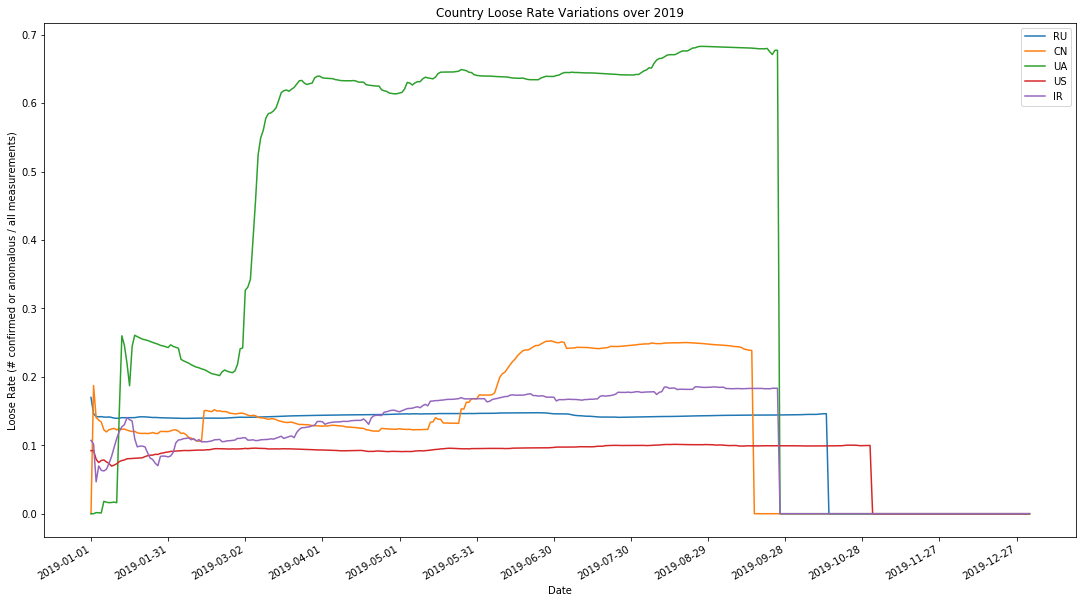

In [16]:
fig = plt.figure(figsize=(18.5, 10.5))

for c in list(country_rates.items()):
    plt.plot(dates_2019, c[1]["cumul_loose_rate"], label = c[0])

plt.xticks(dates_2019[::30])

plt.title("Country Loose Rate Variations over 2019")
plt.xlabel("Date")
plt.ylabel("Loose Rate (# confirmed or anomalous / all measurements)")

plt.gcf().autofmt_xdate()

plt.legend()

plt.matplotlib.pyplot.show()

Check the number of rows in the Ukraine dataframe -- 366 indicates that we have the same number of rows as expected for all days in 2019.

In [37]:
ua_2019 = country_rates["UA"]
print(len(ua_2019))
ua_2019.loc[ua_2019.cumul_loose_rate == 0].head()

366


num_anomaly  num_measurements  num_confirmed  \
measurement_start_date                                                 
2019-01-01                      0.0               131              0   
2019-01-02                      0.0               216              0   
2019-04-24                      0.0                 0              0   
2019-06-05                      0.0                 0              0   
2019-06-06                      0.0                 0              0   

                        cumul_strict_rate  cumul_loose_rate  
measurement_start_date                                       
2019-01-01                            0.0               0.0  
2019-01-02                            0.0               0.0  
2019-04-24                            0.0               0.0  
2019-06-05                            0.0               0.0  
2019-06-06                            0.0               0.0

Use a basic AR model from the statsmodels library to make a time-series-based prediction of how cumulative loose rates are likely to vary in the future (for the rest of the days in 2019).

In [70]:
# AR example
from statsmodels.tsa.ar_model import AR

country_pred = {}

for c in list(country_rates.keys()):
    curr_df = country_rates[c]
    data = curr_df["cumul_loose_rate"][:240]
    model = AR(data, dates = dates_2019, missing = 'drop', freq = 'D')
    model_fit = model.fit()
    yhat = model_fit.predict(start=datetime.datetime(2019, 8, 28), end=datetime.datetime(2019,12,31))
    country_pred[c] = yhat

In [74]:
ua_pred = country_pred["CN"]
ua_pred.head()

2019-08-28    0.248641
2019-08-29    0.248166
2019-08-30    0.248086
2019-08-31    0.248097
2019-09-01    0.248068
Freq: D, dtype: float64

Use the first 240 data points (ends somewhere in August, where sharp drops began to occur in certain countries for loose rate as data stopped being collected in a staggered fashion) as a training set. The dotted lines per country correspond to predictions made about how loose rates may vary in the future absent noise / significant shocks.

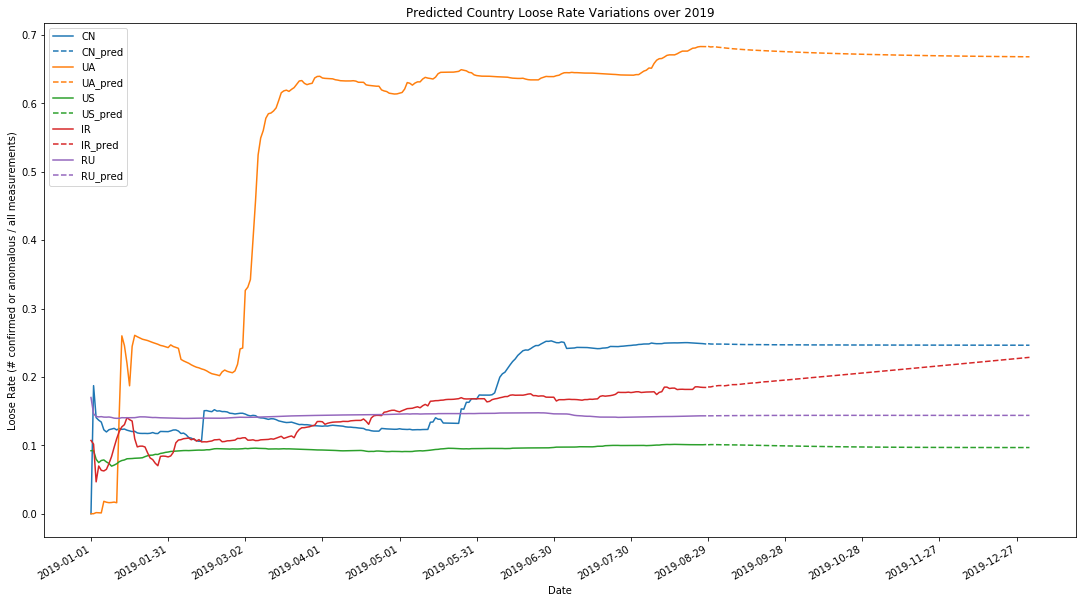

In [77]:
fig = plt.figure(figsize=(18.5, 10.5))
count = 0

for c in list(country_rates.keys()):
    plt.plot(dates_2019[:240], country_rates[c]["cumul_loose_rate"][:240], label = c, color = 'C' + str(count))
    plt.plot(dates_2019[240:], country_pred[c], "--", label = c + "_pred", color = 'C' + str(count))
    count += 1

plt.xticks(dates_2019[::30])

plt.title("Predicted Country Loose Rate Variations over 2019")
plt.xlabel("Date")
plt.ylabel("Loose Rate (# confirmed or anomalous / all measurements)")

plt.gcf().autofmt_xdate()

plt.legend()

plt.matplotlib.pyplot.show()

## Rates by Day and Input

The following cells generally follow the same pattern as the section above ("Rates by Day and Input") when it comes to creating intermediate date_inputs counts i.e. the inputs, per day, and their corresponding confirmed, anomalous, and total measurements counts.

No analysis has been done with this data so far, but this could be a useful thing to look at in the future.

In [4]:
import pandas as pd
import sqlalchemy as sql
import matplotlib.pyplot as plt
import numpy
import plotly.express as px
import pycountry
import datetime
import numpy as np
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

sql_engine = sql.create_engine('postgresql:///metadb')

file_num = 1

In [5]:
measurements_2019_12 = pd.read_csv("data/measurements_2019/measurements_2019_" + str(file_num) + ".csv")
meas_12_len = len(measurements_2019_12)
print(meas_12_len)
measurements_2019_12.head()

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:3049: DtypeWarning:

Columns (12,15,16) have mixed types. Specify dtype option on import or set low_memory=False.



6669668


Unnamed: 0     msm_no  report_no  frame_off  frame_size  intra_off  \
0           0  259867134    7193660    1428496      126258     193049   
1           1  259933375    7198635    2688482       19597     165624   
2           2  259933541    7198636    2708079       19410      55847   
3           3  259933584    7198636    2708079       19410      94757   
4           4  259933844    7198637    2727489       19400      69353   

   intra_size measurement_start_time  test_runtime  \
0      221333    2019-01-01 00:11:23      3.318370   
1         906    2019-01-01 00:18:19      6.904970   
2         906    2019-01-01 00:16:08      0.130566   
3         919    2019-01-01 00:16:30      8.417020   
4         908    2019-01-01 00:20:45      0.000798   

                    orig_sha1                                    id  \
0  <memory at 0x7fee7e2f5588>  df38df8b-89b7-4439-818e-0385c8c23b63   
1  <memory at 0x7fee7e2f5648>  01b34e61-677c-4999-9b17-899d6a640582   
2  <memory at 0x7fee7e2f5708>  62f55bf5-dc6e-4a4a-801b-48610bad538a   
3  <memory at 0x7fee7e2f57c8>  7891b01c-a69a-477c-b46a-88cf7d876f72   
4  <memory at 0x7fee7e2f5888>  bf4d5934-71b3-488e-b988-4a7df0df7a21   

     input_no  exc  residual_no  msm_failure anomaly confirmed  
0   4958147.0  NaN       930787          NaN     NaN       NaN  
1  10057893.0  NaN       878821          NaN     NaN       NaN  
2   6222793.0  NaN       878821          NaN     NaN       NaN  
3   4523274.0  NaN       878821          NaN     NaN       NaN  
4   6227664.0  NaN       878821          NaN     NaN       NaN

In [ ]:
curr_meas_2019 = measurements_2019_12

reports_2019 = pd.read_csv("reports/reports-2019.csv")
inputs = pd.read_sql_query("SELECT * from input", sql_engine)

meas_2019_joined = curr_meas_2019.merge(reports_2019, on = "report_no", how = "left")
meas_2019_joined = meas_2019_joined.merge(inputs, on = "input_no", how = "left")

In [ ]:
# group by date and country code
meas_2019_joined['measurement_start_date'] = meas_2019_joined['measurement_start_time'].apply(lambda x: x[:10])
meas_2019_date_groups = meas_2019_joined.groupby(["measurement_start_date", "probe_cc", "input"])

meas_2019_date_groups.first()

In [ ]:
meas_2019_dates_inputs = meas_2019_date_groups.agg({"confirmed": "sum", "anomaly": "sum", "report_no": "count"})
meas_2019_dates_inputs.head()

In [ ]:
meas_2019_dates_inputs.rename(columns={"report_no": "num_measurements", "confirmed": "num_confirmed", "anomaly": "num_anomaly"}, inplace = True)
meas_2019_dates_inputs.head()

In [ ]:
meas_2019_dates_inputs.to_csv("date_counts/2019/date_inputs_2019_cc_" + str(file_num))

## Measurement Analysis: User Input Year

The below includes generalized code that can be used to calculate overall yearly rate files based on a user input year.

In [2]:
import numpy as np
import pandas as pd
import sqlalchemy as sql
import matplotlib.pyplot as plt
import plotly.express as px
import pycountry
import datetime
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

sql_engine = sql.create_engine('postgresql:///metadb')

Specify year and measurement file number (from generated measurements_(file_no).csv files for the year in the current directory).

In [3]:
year = 2017

In [ ]:
file_no = 12

Read the csv file rows into a dataframe.

In [6]:
measurements = pd.read_csv("measurements_" + str(year) + "_" + str(file_no) + ".csv")
meas_len = len(measurements)
print(meas_len)
measurements.head()

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:3049: DtypeWarning:

Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.



7819280


Unnamed: 0     msm_no  report_no  frame_off  frame_size  intra_off  \
0           0  128480240    2918504    2357660       71249      50249   
1           1  128495492    2918517   19980602       79943      96002   
2           2  128512127    2918532   20006737      102333       3197   
3           3  128514301    2918534   19279268       73516      52630   
4           4  128526941    2918546    5057602      385675      67453   

   intra_size measurement_start_time  test_runtime  \
0        9966    2017-10-16 03:30:35      0.722870   
1       39400    2017-10-16 00:35:19      1.574580   
2       39405    2017-10-16 00:31:34      1.326560   
3       28670    2017-10-16 00:30:13      1.615630   
4       45753    2017-10-16 00:48:52      0.254655   

                    orig_sha1                                    id  \
0  <memory at 0x7f56b5d7ac48>  d136be96-9423-4af0-8ddf-5995ac806b9d   
1  <memory at 0x7f56b5d7ad08>  c6fec3ca-3e4d-47ef-a15b-6c0f6a16d4e7   
2  <memory at 0x7f56b5d7adc8>  f7bc2882-16f4-49b2-92b5-25a44cd4cc82   
3  <memory at 0x7f56b5d7ae88>  feb018df-d4ba-4525-8773-504e77d47fa0   
4  <memory at 0x7f56b5d7af48>  95c63bae-9f56-4566-9a8f-58e35aae2268   

    input_no  exc  residual_no  msm_failure anomaly confirmed  
0  1843489.0  NaN       848346          NaN     NaN       NaN  
1       94.0  NaN       848346          NaN     NaN       NaN  
2       94.0  NaN       848346          NaN     NaN       NaN  
3      467.0  NaN       848346          NaN     NaN       NaN  
4  4960660.0  NaN       848346          NaN     NaN       NaN

In an earlier command, you should have written the reports corresponding to the year in the reports-(year).csv file in the same directory. If these weren't written, it's fine as long as they are accessible in the reports variable for a few lines below during the join. I wrote these to a file temporarily because making the same SQL call multiple times felt redundant, and there is a higher chance of the kernel dying from a memory error otherwise.

In [7]:
reports = pd.read_csv("reports-" + str(year) + ".csv")

In [8]:
len(reports)

1320835

Correlate each measurement to a country code by joining the reports table with measurements on the report_no column.

In [9]:
meas_report_join = measurements.merge(reports, on = "report_no", how = "left")
meas_report_join.head()

Unnamed: 0_x     msm_no  report_no  frame_off  frame_size  intra_off  \
0             0  128480240    2918504    2357660       71249      50249   
1             1  128495492    2918517   19980602       79943      96002   
2             2  128512127    2918532   20006737      102333       3197   
3             3  128514301    2918534   19279268       73516      52630   
4             4  128526941    2918546    5057602      385675      67453   

   intra_size measurement_start_time  test_runtime  \
0        9966    2017-10-16 03:30:35      0.722870   
1       39400    2017-10-16 00:35:19      1.574580   
2       39405    2017-10-16 00:31:34      1.326560   
3       28670    2017-10-16 00:30:13      1.615630   
4       45753    2017-10-16 00:48:52      0.254655   

                  orig_sha1_x  ...      test_start_time  probe_cc probe_asn  \
0  <memory at 0x7f56b5d7ac48>  ...  2017-10-16 00:00:20        ES    3352.0   
1  <memory at 0x7f56b5d7ad08>  ...  2017-10-16 00:00:52        FR    3215.0   
2  <memory at 0x7f56b5d7adc8>  ...  2017-10-16 00:07:42        GB   12876.0   
3  <memory at 0x7f56b5d7ae88>  ...  2017-10-16 00:07:47        US     209.0   
4  <memory at 0x7f56b5d7af48>  ...  2017-10-16 00:41:47        CA   32489.0   

   probe_ip         test_name badtail  \
0       NaN  web_connectivity     NaN   
1       NaN  web_connectivity     NaN   
2       NaN  web_connectivity     NaN   
3       NaN  web_connectivity     NaN   
4       NaN  web_connectivity     NaN   

                                            textname  \
0  2017-10-17/20171016T000020Z-ES-AS3352-web_conn...   
1  2017-10-17/20171016T000052Z-FR-AS3215-web_conn...   
2  2017-10-17/20171016T000742Z-GB-AS12876-web_con...   
3  2017-10-17/20171016T000747Z-US-AS209-web_conne...   
4  2017-10-17/20171016T004147Z-CA-AS32489-web_con...   

                  orig_sha1_y  \
0  <memory at 0x7f0aeb409e88>   
1  <memory at 0x7f0aeb410888>   
2  <memory at 0x7f0aeb4164c8>   
3  <memory at 0x7f0aeb416648>   
4  <memory at 0x7f0aeb416f48>   

                                           report_id software_no  
0  20171016T000022Z_AS3352_yiYpXqzLMxPiAGmC3oWL7O...       499.0  
1  20171016T000053Z_AS3215_86CNTNTnrN4X7Gw769gxAd...       499.0  
2  20171016T000742Z_AS12876_UHkAlVBlpsWyBHdjmx5V2...       499.0  
3  20171016T000748Z_AS209_vdKghg8HfJ2tou4khSt5iiK...       499.0  
4  20171016T004147Z_AS32489_Xt0WD2Kq7VFa3NJQGwP7F...       670.0  

[5 rows x 29 columns]

Group each new row of this joined table by country code.

In [10]:
# count confirmed by country
country_groups = meas_report_join.groupby("probe_cc")
country_groups.first()

Unnamed: 0_x     msm_no  report_no  frame_off  frame_size  \
probe_cc                                                              
AD               36706  138200989    3119616   14105722       87487   
AE                  48  128433938    2916528    8107043      114717   
AF               23260  134454192    3013538   12545499       90726   
AG              160507  103370604    2248625    4910166       77247   
AL                6409  129926699    2943365   10573402       73378   
AM                4365  129403915    2931882   12510711       62148   
AO               47552  140943568    3203665    3469011       62046   
AP               44589  140181178    3182294   11751380      130454   
AR                 466  128446737    2917207     231221       19250   
AT                 207  128488390    2918511   10498777       97567   
AU                   5  128544471    2918561   21828843       54695   
AW               76588  150610257    3595301    2264481       55489   
AX               90569   92697685    2102882      61403       59900   
AZ               29914  136426176    3061568    1832314       58200   
BA               46599  140673632    3192252   13167861       75126   
BB               34345   62995214    1363815   10003853      163308   
BD               15092  132180952    2982360   12862097      125898   
BE                7563  130174812    2946433    4837280       75091   
BF              215976   76759083    1865327   15982511       81729   
BG                 495  128553848    2918570    9610507       82630   
BH               39731  138909127    3137852   10201061       41412   
BI                 342  128636826    2918647    5636870      279044   
BJ              105021   59046659    1315398   12795866      204644   
BM              251343  142686528    3261125    6001986       62391   
BN              131477   77163009    1881443    3962334       76078   
BO               46433  140682274    3194804    2810754       59069   
BQ               60829  144566709    3328026    2204685       59880   
BR                  17  128589926    2918603   22254309       76121   
BS               92334   34799509     845054    6967952       85211   
BT              104887  140174830    3178729    1201040       60061   
...                ...        ...        ...        ...         ...   
SY               29945  136687339    3072003    4924476       59901   
SZ              164174   91607544    2089013    3885593       92574   
TC              320127   78544537    1918631   12694533       45346   
TD              227204   81278017    1967703   12872309       70307   
TG               24027  134498288    3015676   14532375       67721   
TH                 119  128538608    2918556   19657741       74981   
TJ               32801  137189839    3083425    1038978       60448   
TL               47435  140945339    3205436    5543340       62194   
TM               27880  136150735    3054971    2087822       61032   
TN                7431  130161462    2945588    8673056       70367   
TR                  74  128612468    2918624    4712049       95315   
TT               70385  147012754    3417616   13004500       97061   
TW                 677  128677882    2922903    3127779       94922   
TZ                6510  130305957    2948900     226524       70225   
UA                 440  128443938    2917188      57524       19143   
UG                3620  129631101    2934081    1159517       71436   
US                   3  128514301    2918534   19279268       73516   
UY               22243  133997402    3009362    5482833       83517   
UZ               31799  136937146    3075719     306889       61715   
VC               37507   77634902    1895142     156326      184888   
VE                1529  129059674    2927455   15561985       66502   
VI              245954  140932903    3200365   10161643       71214   
VN               26778  135668623    3041120    8240488      227884   
VU              240524  139927839 

Sum all confirmed and anomalous events, and count report_no to keep track of the total number of measurements.

In [11]:
rates = country_groups.agg({"confirmed": "sum", "anomaly": "sum", "report_no": "count"})
rates["num_no_confirmed_interference"] = rates["report_no"] - rates['confirmed']
rates.head()

report_no  anomaly  confirmed  num_no_confirmed_interference
probe_cc                                                              
AD               11        0          0                             11
AE            13060     1008          0                          13060
AF             3320      894          0                           3320
AG                4        0          0                              4
AL             1020       31          0                           1020

Write intermediate rate calculations to a file.

<b>Now, go back to the first step of this section, and repeat the process for all measurement files for the year (currently, 12).</b>

In [12]:
rates.to_csv("rates_" + str(year) + "_" + str(file_no) + ".csv")

This cell loads all intermediate rate dataframes into an aggregate all_rates dataframe.

<b>Note</b>: Change the range limits if there are a different number of intermediate rate files corresponding to the year.

In [8]:
all_rates = pd.read_csv("rates_" + str(year) + "_1.csv")
for i in range(2, 13):
    new_rates_df = pd.read_csv("rates_" + str(year) + "_" + str(i) + ".csv")
    all_rates = pd.concat([all_rates, new_rates_df], axis = 0, sort = True)
print(len(all_rates))
all_rates.head()

2544


anomaly  confirmed  num_no_confirmed_interference probe_cc  report_no
0       0          0                             14       AD         14
1     729          0                          10006       AE      10006
2     596          0                           2638       AF       2638
3       0          0                              5       AG          5
4      27          0                            771       AL        771

Coerce the anomaly column to integer type so grouping by sum doesn't drop it as a 'difficult' column.

In [18]:
all_rates.anomaly = pd.to_numeric(all_rates.anomaly, errors='coerce').fillna(0).astype(int)

Group the all_rates dataframe by country code so we don't have multiple rows per country corresponding to each rate file.

In [22]:
grouped_counts = all_rates.groupby("probe_cc").sum()
print(len(grouped_counts))
grouped_counts.head()

221


anomaly  confirmed  num_no_confirmed_interference  report_no
probe_cc                                                              
AD              2          0                            139        139
AE           9472          0                         118453     118453
AF           7492          0                          30611      30611
AG              0          0                             53         53
AL            280          0                           9192       9192

Determine strict and loose rates for each country in 2017.

In [23]:
grouped_counts["strict_rate"] = grouped_counts['confirmed'] / grouped_counts['report_no']
grouped_counts["loose_rate"] = (grouped_counts['confirmed'] + grouped_counts['anomaly']) / grouped_counts['report_no']
grouped_counts.head()

anomaly  confirmed  num_no_confirmed_interference  report_no  \
probe_cc                                                                 
AD              2          0                            139        139   
AE           9472          0                         118453     118453   
AF           7492          0                          30611      30611   
AG              0          0                             53         53   
AL            280          0                           9192       9192   

          strict_rate  loose_rate  
probe_cc                           
AD                0.0    0.014388  
AE                0.0    0.079964  
AF                0.0    0.244749  
AG                0.0    0.000000  
AL                0.0    0.030461

Rename columns and the index to more intuitive names based on what they're measuring.

In [24]:
grouped_counts.drop(['report_no'], axis = 1, inplace = True)
grouped_counts = grouped_counts.rename(index = {"probe_cc": "country_code"}, columns={'confirmed': 'num_confirmed_interference', 'anomaly': "num_anomaly"})
grouped_counts = grouped_counts.rename_axis("country_code")

grouped_counts.head()

num_anomaly  num_confirmed_interference  \
country_code                                            
AD                      2                           0   
AE                   9472                           0   
AF                   7492                           0   
AG                      0                           0   
AL                    280                           0   

              num_no_confirmed_interference  strict_rate  loose_rate  
country_code                                                          
AD                                      139          0.0    0.014388  
AE                                   118453          0.0    0.079964  
AF                                    30611          0.0    0.244749  
AG                                       53          0.0    0.000000  
AL                                     9192          0.0    0.030461

Change column order in the final dataframe.

In [25]:
columnsTitles = ["num_confirmed_interference", "num_anomaly", "num_no_confirmed_interference", "strict_rate", "loose_rate"]
new_rates = grouped_counts.reindex(columns = columnsTitles)
new_rates.head()

num_confirmed_interference  num_anomaly  \
country_code                                            
AD                                     0            2   
AE                                     0         9472   
AF                                     0         7492   
AG                                     0            0   
AL                                     0          280   

              num_no_confirmed_interference  strict_rate  loose_rate  
country_code                                                          
AD                                      139          0.0    0.014388  
AE                                   118453          0.0    0.079964  
AF                                    30611          0.0    0.244749  
AG                                       53          0.0    0.000000  
AL                                     9192          0.0    0.030461

Write the final interference measurements dataframe to a file.

In [26]:
new_rates.to_csv("interference-measurements-by-country-" + str(year) + "-full.csv")